<a href="https://colab.research.google.com/github/Keesp21/ML_Projct/blob/main/Machine_Learning_Project_LEBEAU_PATHMASRI_NASSOUR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
#   0. IMPORTS & CONFIG
# ============================

import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

plt.style.use("seaborn-v0_8")
sns.set_theme()


In [ ]:
# =====================================
# 1. GET S&P 500 TICKERS (NO WIKIPEDIA)
# =====================================

import pandas as pd

sp500_url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"

sp500_table = pd.read_csv(sp500_url)

tickers = sp500_table["Symbol"].tolist()

# Yahoo Finance remplace "." par "-"
tickers = [t.replace(".", "-") for t in tickers]

print(f"Nombre de tickers récupérés : {len(tickers)}")
tickers[:15]


Nombre de tickers récupérés : 503


['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE']

In [ ]:
# =====================================
# 2. DOWNLOAD ADJ CLOSE PRICES (10 YEARS)
# =====================================

import yfinance as yf
import pandas as pd
import numpy as np

start_date = "2014-01-01"
end_date = None  # jusqu'à aujourd'hui

raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,   # important pour avoir 'Adj Close'
    progress=True
)

print("Raw shape (with OHLC etc.):", raw.shape)

# Si yfinance renvoie un MultiIndex (Open/High/Low/Close/Adj Close)
if isinstance(raw.columns, pd.MultiIndex):
    # On prend seulement les prix 'Adj Close'
    data_raw = raw["Adj Close"].copy()
else:
    # Sinon on suppose que ce sont directement les prix
    data_raw = raw.copy()

# On retire les colonnes complètement vides (ex: WBA)
data_raw = data_raw.dropna(axis=1, how="all")

print("Shape after dropping all-NaN columns:", data_raw.shape)
print("First columns:", data_raw.columns[:10])

data_raw.head()


[**********************77%************           ]  387 of 503 completedERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['ARE', 'F']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
ERROR:yfinance:['WBA']: YFTzMissingError('possibly delisted; no timezone found')


Raw shape (with OHLC etc.): (2995, 3018)
Shape after dropping all-NaN columns: (2995, 500)
First columns: Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       'ADM'],
      dtype='object', name='Ticker')


Ticker              A       AAPL       ABBV  ABNB        ABT       ACGL  \
Date                                                                      
2014-01-02  36.451370  17.156696  32.166573   NaN  30.329454  18.184349   
2014-01-03  36.911797  16.779844  32.364620   NaN  30.654730  17.835686   
2014-01-06  36.730221  16.871342  31.182640   NaN  31.059326  17.667694   
2014-01-07  37.255482  16.750685  31.244539   NaN  30.821325  17.674034   
2014-01-08  37.865082  16.856768  31.164085   NaN  31.099010  17.569435   

Ticker            ACN       ADBE        ADI        ADM  ...         WY  \
Date                                                    ...              
2014-01-02  66.105835  59.290001  38.389385  30.486380  ...  19.906202   
2014-01-03  66.325851  59.160000  38.646446  30.628202  ...  19.950771   
2014-01-06  65.625122  58.119999  38.428337  30.692036  ...  19.747063   
2014-01-07  66.423637  58.970001  38.630878  30.387091  ...  19.804352   
2014-01-08  66.936981  58.900002  38.724358  30.039619  ...  19.619740   

Ticker            WYNN        XEL        XOM        XYL  XYZ        YUM  \
Date                                                                      
2014-01-02  164.399765  18.877495  60.518341  29.326864  NaN  43.131615   
2014-01-03  162.788452  18.870630  60.372734  29.593021  NaN  43.401596   
2014-01-06  162.672256  18.767706  60.463730  29.541491  NaN  43.367119   
2014-01-07  167.364822  19.090218  61.319172  29.627346  NaN  43.975983   
2014-01-08  170.504364  19.014740  61.118977  29.610186  NaN  43.958759   

Ticker            ZBH       ZBRA        ZTS  
Date                                         
2014-01-02  81.395821  53.180000  29.439472  
2014-01-03  81.748810  53.580002  29.157448  
2014-01-06  82.278252  53.400002  29.093767  
2014-01-07  83.919617  53.950001  29.202938  
2014-01-08  85.975693  53.910000  28.875422  

[5 rows x 500 columns]

In [ ]:
# =====================================
# 3. CLEANING: DROP BAD TICKERS & FILL NAs
# =====================================

# On garde seulement les colonnes qui ont au moins 80% de données non-NA
min_non_na = int(0.8 * len(data_raw))

valid_cols = [c for c in data_raw.columns if data_raw[c].count() >= min_non_na]
data = data_raw[valid_cols]

print(f"Tickers valides (>=80% données) : {len(valid_cols)} / {len(tickers)}")

# On remplit les trous restants par ffill puis bfill
data = data.ffill().bfill()

# On enlève les éventuelles dates entièrement vides (juste au cas où)
data = data.dropna(how="all")

print("Shape after cleaning:", data.shape)
data.head()


Tickers valides (>=80% données) : 469 / 503
Shape after cleaning: (2995, 469)


Ticker              A       AAPL       ABBV        ABT       ACGL        ACN  \
Date                                                                           
2014-01-02  36.451370  17.156696  32.166573  30.329454  18.184349  66.105835   
2014-01-03  36.911797  16.779844  32.364620  30.654730  17.835686  66.325851   
2014-01-06  36.730221  16.871342  31.182640  31.059326  17.667694  65.625122   
2014-01-07  37.255482  16.750685  31.244539  30.821325  17.674034  66.423637   
2014-01-08  37.865082  16.856768  31.164085  31.099010  17.569435  66.936981   

Ticker           ADBE        ADI        ADM        ADP  ...         WY  \
Date                                                    ...              
2014-01-02  59.290001  38.389385  30.486380  54.243252  ...  19.906202   
2014-01-03  59.160000  38.646446  30.628202  54.834190  ...  19.950771   
2014-01-06  58.119999  38.428337  30.692036  54.209309  ...  19.747063   
2014-01-07  58.970001  38.630878  30.387091  54.868153  ...  19.804352   
2014-01-08  58.900002  38.724358  30.039619  54.576084  ...  19.619740   

Ticker            WYNN        XEL        XOM        XYL    XYZ        YUM  \
Date                                                                        
2014-01-02  164.399765  18.877495  60.518341  29.326864  13.07  43.131615   
2014-01-03  162.788452  18.870630  60.372734  29.593021  13.07  43.401596   
2014-01-06  162.672256  18.767706  60.463730  29.541491  13.07  43.367119   
2014-01-07  167.364822  19.090218  61.319172  29.627346  13.07  43.975983   
2014-01-08  170.504364  19.014740  61.118977  29.610186  13.07  43.958759   

Ticker            ZBH       ZBRA        ZTS  
Date                                         
2014-01-02  81.395821  53.180000  29.439472  
2014-01-03  81.748810  53.580002  29.157448  
2014-01-06  82.278252  53.400002  29.093767  
2014-01-07  83.919617  53.950001  29.202938  
2014-01-08  85.975693  53.910000  28.875422  

[5 rows x 469 columns]

Date range: 2014-01-02 00:00:00 → 2025-11-26 00:00:00
Number of assets: 469


count       mean        std        min        25%        50%  \
Ticker                                                                  
A       2995.0  87.308830  41.020297  30.781536  44.283224  75.628418   
AAPL    2995.0  97.779158  73.685615  15.501920  28.785412  63.263439   
ABBV    2995.0  90.938984  52.135710  29.209167  44.519960  70.558990   
ABT     2995.0  75.916697  33.530570  28.600323  38.523653  76.336929   
ACGL    2995.0  43.224001  25.446317  16.666082  25.144926  31.522287   

               75%         max  
Ticker                          
A       127.016251  174.067657  
AAPL    162.125412  277.549988  
ABBV    133.217972  242.630859  
ABT     105.653633  138.334610  
ACGL     56.892260  109.220207

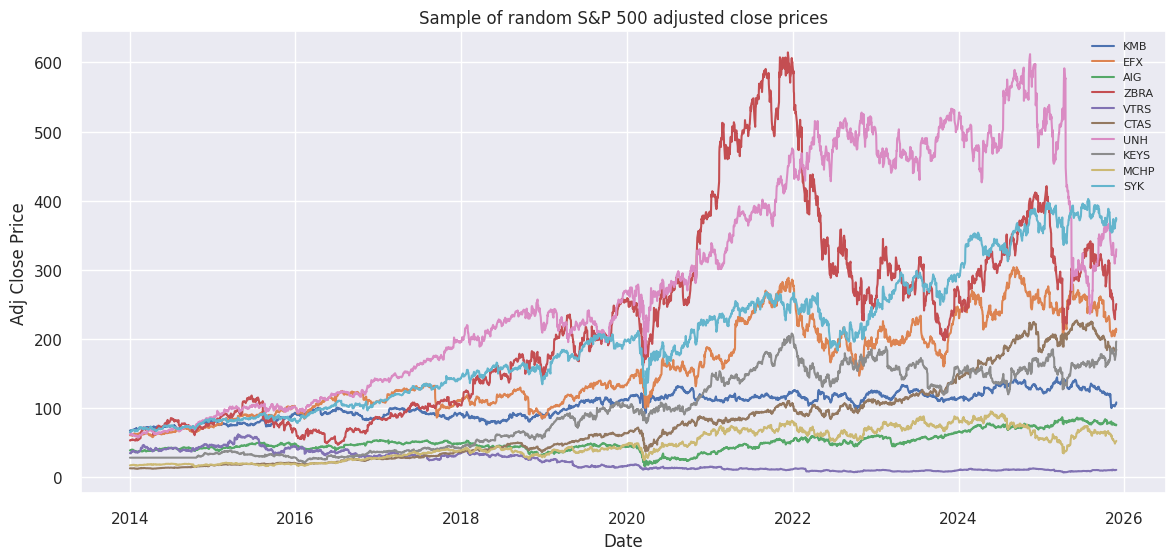

In [ ]:
# =====================================
# 4A. QUICK EDA ON CLEANED DATA (PRICES)
# =====================================

print("Date range:", data.index.min(), "→", data.index.max())
print("Number of assets:", data.shape[1])

display(data.describe().T.head())

# Sample of 10 random tickers
sample_cols = np.random.choice(data.columns, size=min(10, data.shape[1]), replace=False)

plt.figure(figsize=(14,6))
plt.plot(data.index, data[sample_cols])
plt.title("Sample of random S&P 500 adjusted close prices")
plt.xlabel("Date")
plt.ylabel("Adj Close Price")
plt.legend(sample_cols, fontsize=8)
plt.show()

# === IMPORTANT ===
# Rendements quotidiens pour la corrélation
returns = data.pct_change().dropna()



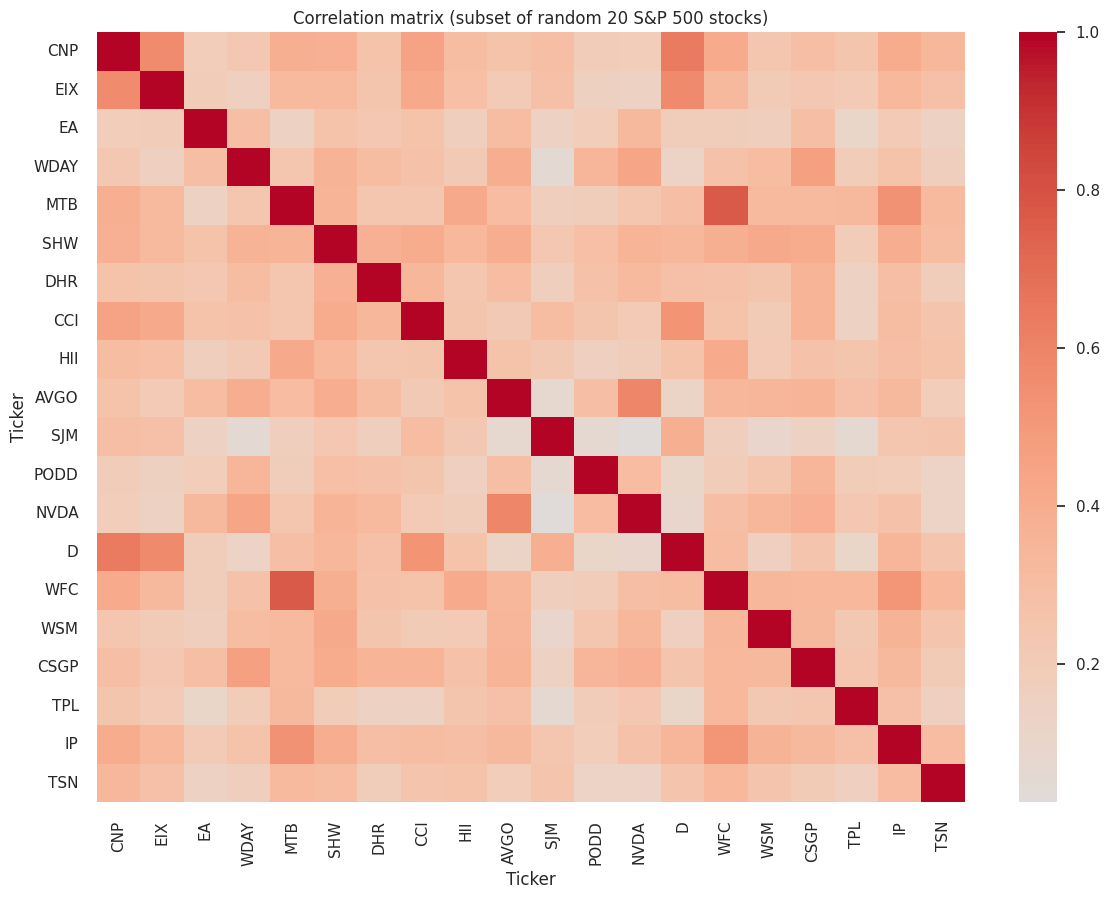

In [ ]:
# =============================================
# 4B. CLEAN HEATMAP ON A SUBSET OF 20 TICKERS
# =============================================

subset_cols = np.random.choice(returns.columns, 20, replace=False)
subset = returns[subset_cols]

plt.figure(figsize=(14, 10))
sns.heatmap(subset.corr(), cmap="coolwarm", center=0)
plt.title("Correlation matrix (subset of random 20 S&P 500 stocks)")
plt.show()


In [ ]:
# =====================================
# 5. EXTRACT STRONGLY CORRELATED PAIRS
# =====================================

corr_matrix = returns.corr()

strong_pairs = []
threshold = 0.80   # corrélation minimale

cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):   # i < j pour éviter doublons
        ti = cols[i]
        tj = cols[j]
        rho = corr_matrix.iloc[i, j]
        if rho >= threshold:
            strong_pairs.append((ti, tj, rho))

strong_pairs_sorted = sorted(strong_pairs, key=lambda x: x[2], reverse=True)

print(f"Nombre de paires avec corr >= {threshold} : {len(strong_pairs_sorted)}")
strong_pairs_sorted[:20]


Nombre de paires avec corr >= 0.8 : 173


[('GOOG', 'GOOGL', np.float64(0.9944043778094224)),
 ('NWS', 'NWSA', np.float64(0.9717054900601181)),
 ('AVB', 'EQR', np.float64(0.9153613318968539)),
 ('EQR', 'UDR', np.float64(0.9132115684526688)),
 ('FRT', 'REG', np.float64(0.9128019659959244)),
 ('MET', 'PRU', np.float64(0.9048120363233407)),
 ('FITB', 'RF', np.float64(0.9046533766376874)),
 ('AVB', 'UDR', np.float64(0.9014252496264055)),
 ('ESS', 'UDR', np.float64(0.8949873373092972)),
 ('EQR', 'ESS', np.float64(0.8939588148376875)),
 ('FITB', 'KEY', np.float64(0.8927375494600766)),
 ('AVB', 'ESS', np.float64(0.8892128751295874)),
 ('DHI', 'LEN', np.float64(0.8890818985816394)),
 ('CFG', 'KEY', np.float64(0.8887908282609196)),
 ('CMS', 'LNT', np.float64(0.8886957283029346)),
 ('MA', 'V', np.float64(0.8884648666963146)),
 ('KEY', 'RF', np.float64(0.888318987169694)),
 ('CFG', 'FITB', np.float64(0.8877561144959664)),
 ('AMAT', 'LRCX', np.float64(0.8863861095740966)),
 ('CMS', 'WEC', np.float64(0.8843987603531753))]

In [ ]:
# =========================================
# SELECT 20 REAL PAIRS (remove duplicates)
# =========================================

# On supprime les paires du type GOOG/GOOGL, NWS/NWSA
invalid = {"GOOG", "GOOGL", "NWS", "NWSA"}

filtered_pairs = [(a,b,c) for (a,b,c) in strong_pairs_sorted if a not in invalid and b not in invalid]

# On garde les 20 premières
top20_pairs = filtered_pairs[:20]

top20_pairs


[('AVB', 'EQR', np.float64(0.9153613318968539)),
 ('EQR', 'UDR', np.float64(0.9132115684526688)),
 ('FRT', 'REG', np.float64(0.9128019659959244)),
 ('MET', 'PRU', np.float64(0.9048120363233407)),
 ('FITB', 'RF', np.float64(0.9046533766376874)),
 ('AVB', 'UDR', np.float64(0.9014252496264055)),
 ('ESS', 'UDR', np.float64(0.8949873373092972)),
 ('EQR', 'ESS', np.float64(0.8939588148376875)),
 ('FITB', 'KEY', np.float64(0.8927375494600766)),
 ('AVB', 'ESS', np.float64(0.8892128751295874)),
 ('DHI', 'LEN', np.float64(0.8890818985816394)),
 ('CFG', 'KEY', np.float64(0.8887908282609196)),
 ('CMS', 'LNT', np.float64(0.8886957283029346)),
 ('MA', 'V', np.float64(0.8884648666963146)),
 ('KEY', 'RF', np.float64(0.888318987169694)),
 ('CFG', 'FITB', np.float64(0.8877561144959664)),
 ('AMAT', 'LRCX', np.float64(0.8863861095740966)),
 ('CMS', 'WEC', np.float64(0.8843987603531753)),
 ('CFG', 'RF', np.float64(0.8822036860944032)),
 ('FITB', 'TFC', np.float64(0.8820494596285314))]


=== PAIR AVB - EQR  (corr = 0.915) ===


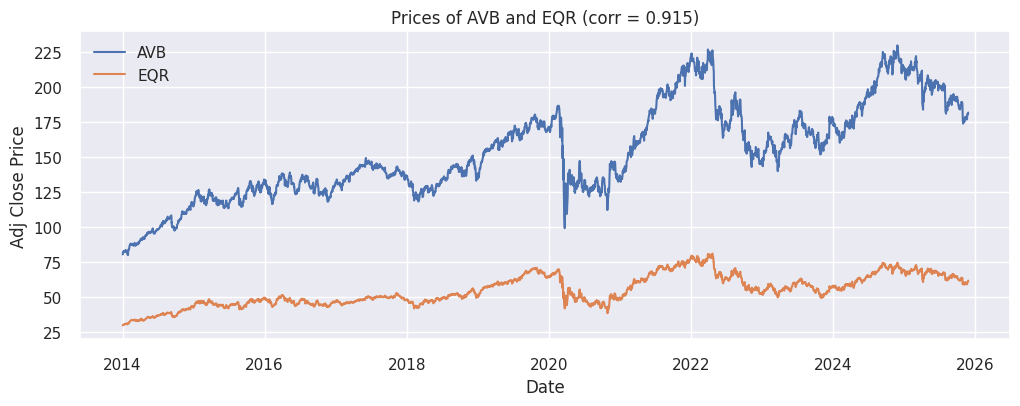

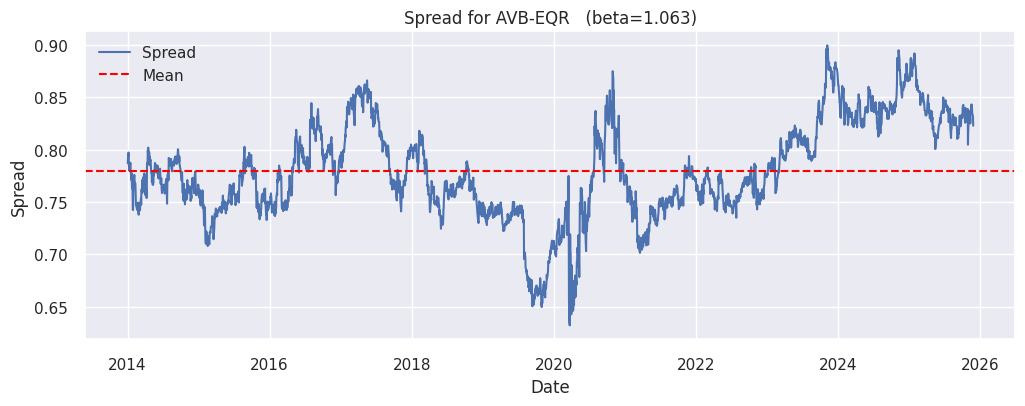

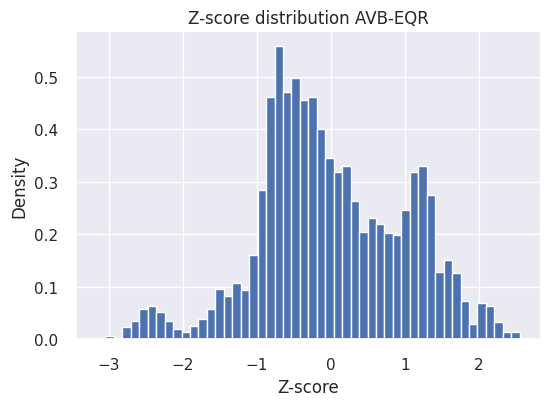


=== PAIR EQR - UDR  (corr = 0.913) ===


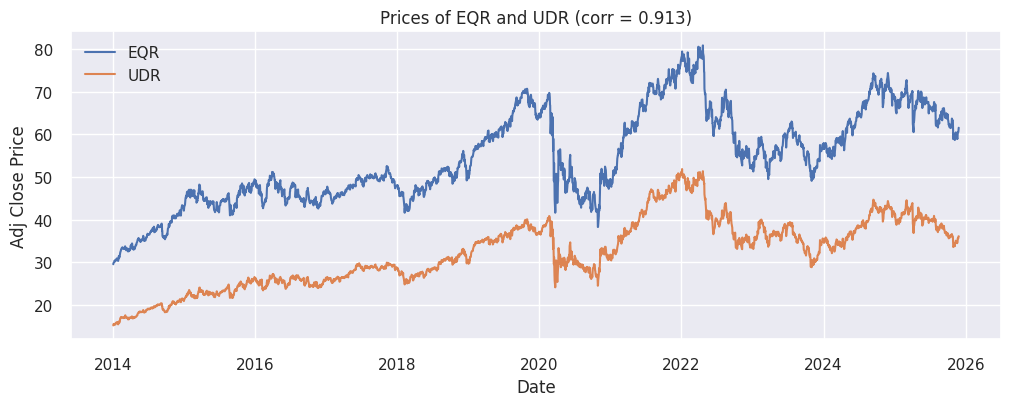

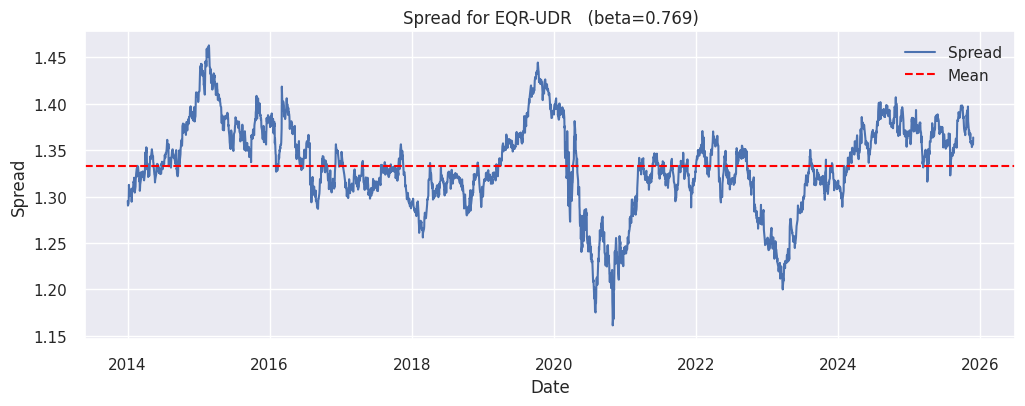

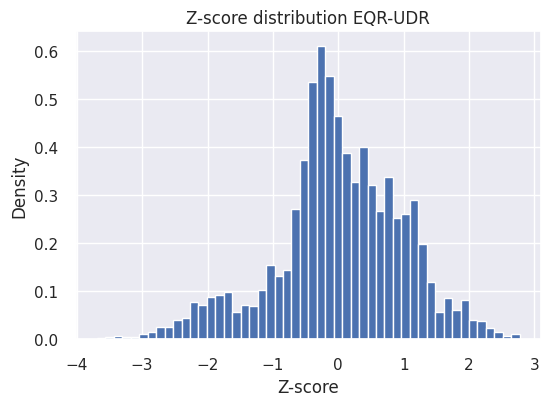


=== PAIR FRT - REG  (corr = 0.913) ===


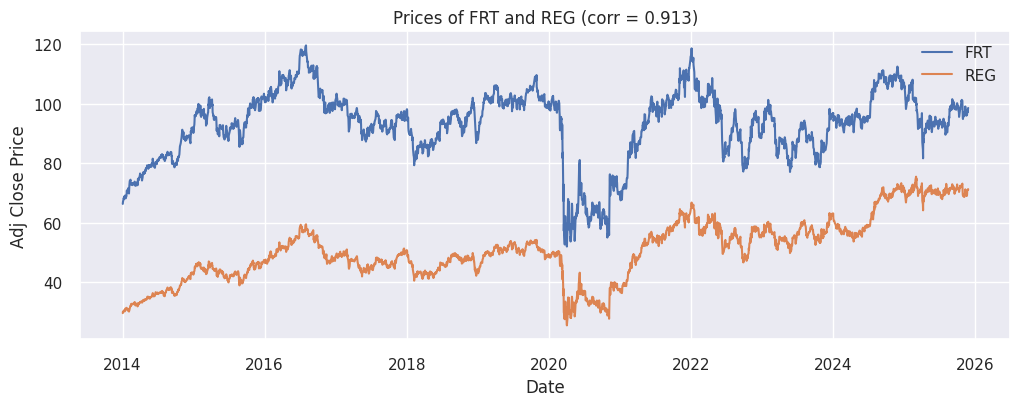

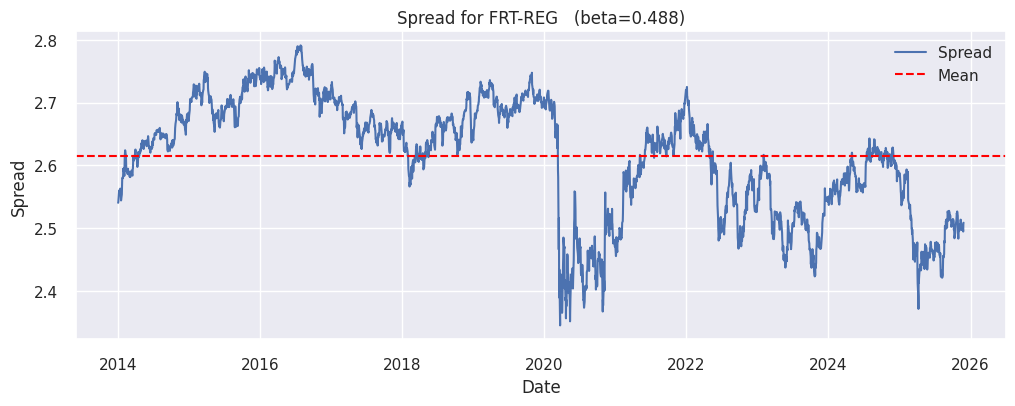

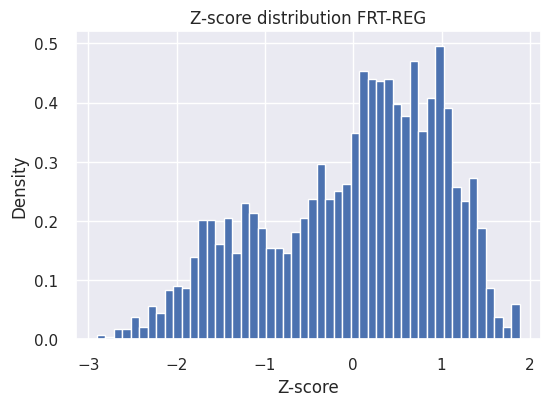


=== PAIR MET - PRU  (corr = 0.905) ===


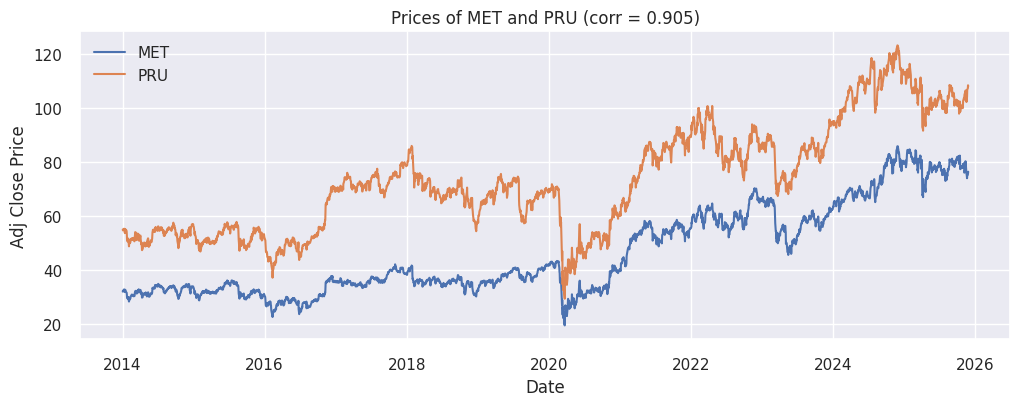

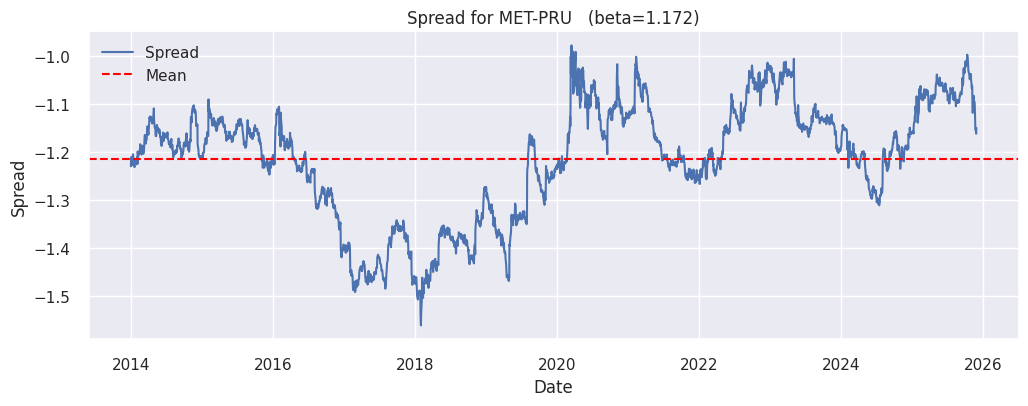

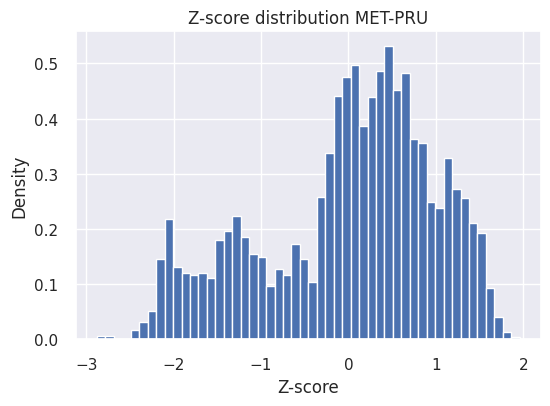


=== PAIR FITB - RF  (corr = 0.905) ===


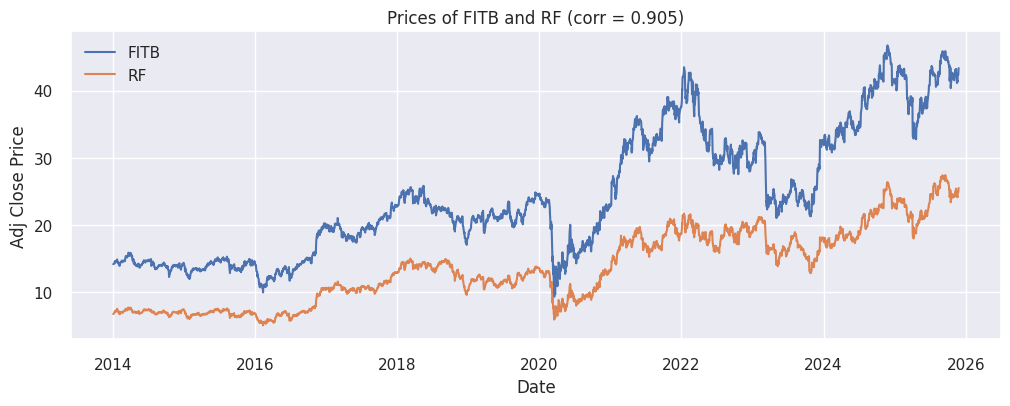

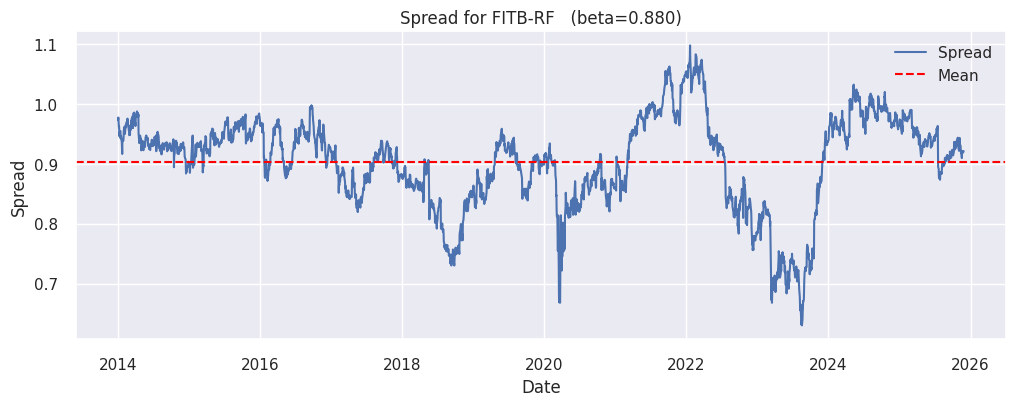

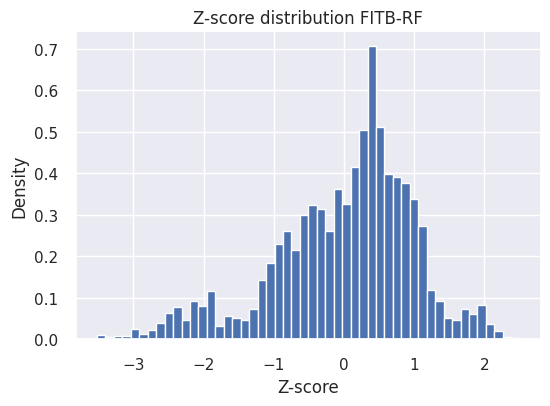


=== PAIR AVB - UDR  (corr = 0.901) ===


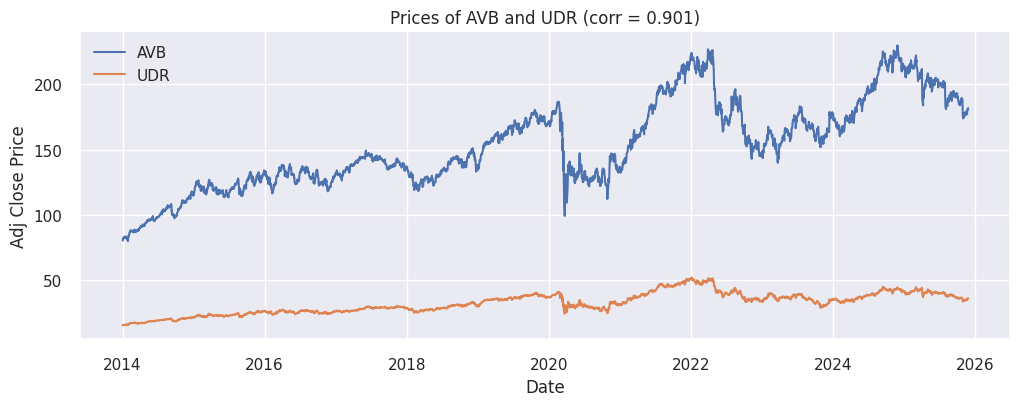

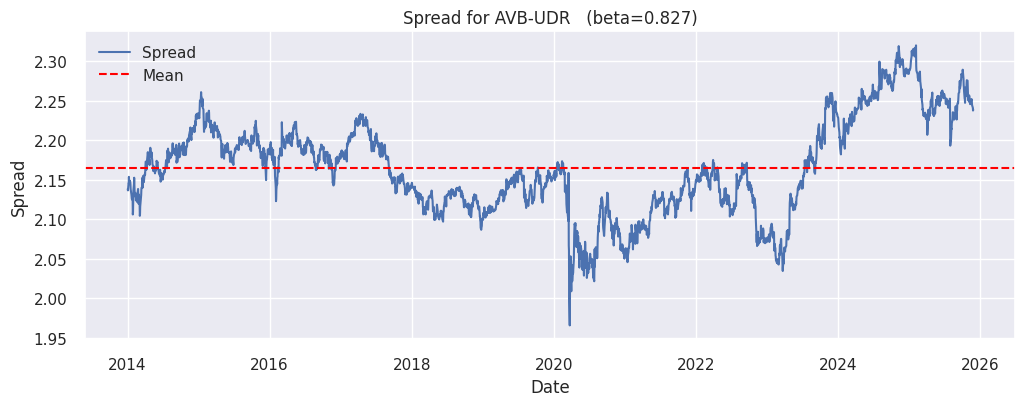

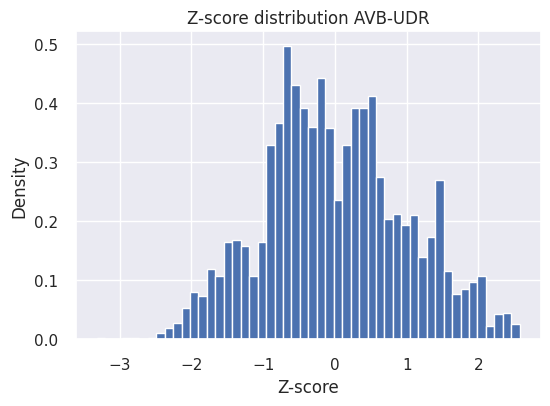


=== PAIR ESS - UDR  (corr = 0.895) ===


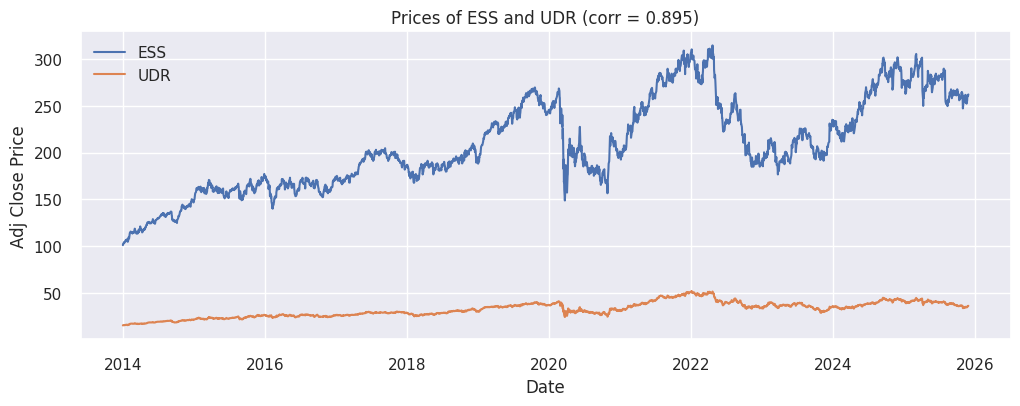

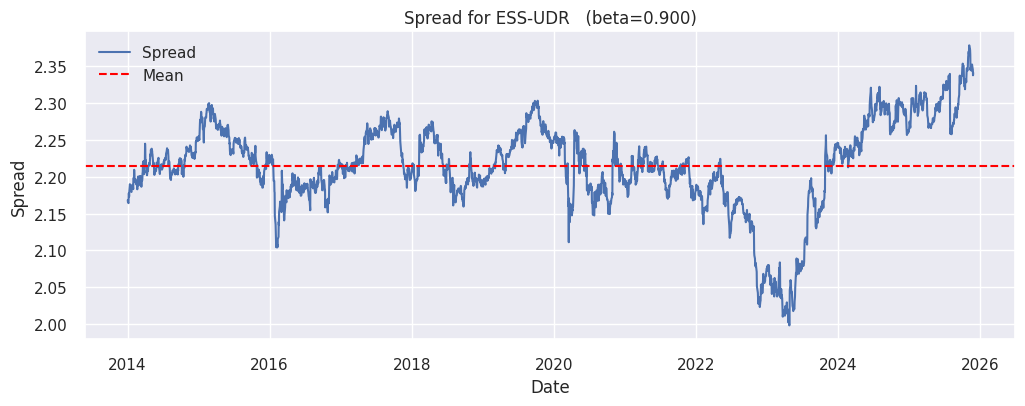

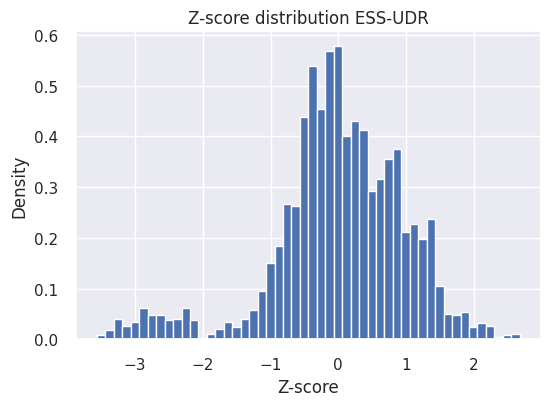


=== PAIR EQR - ESS  (corr = 0.894) ===


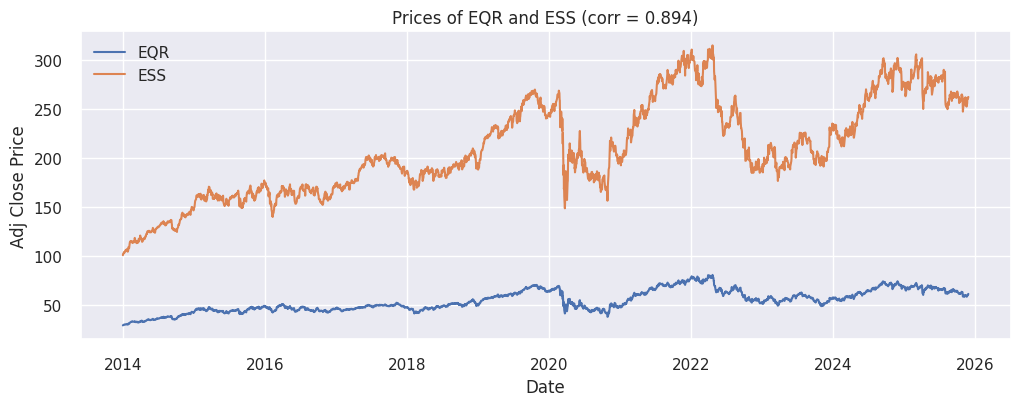

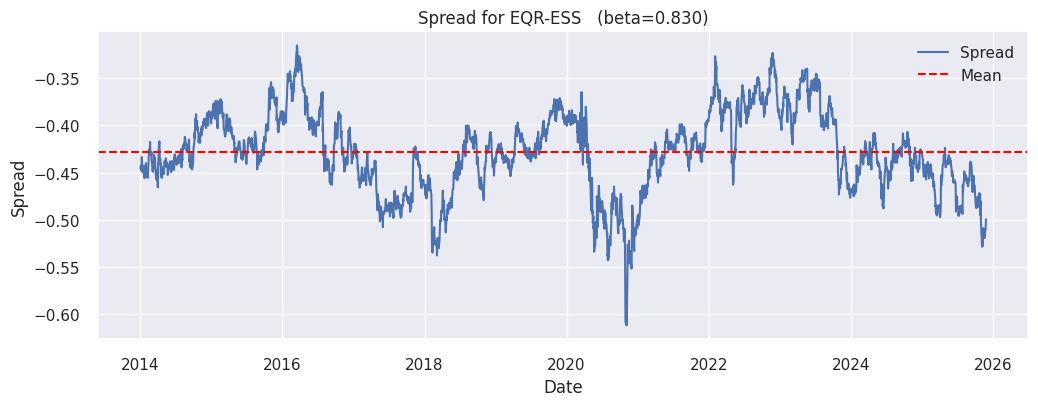

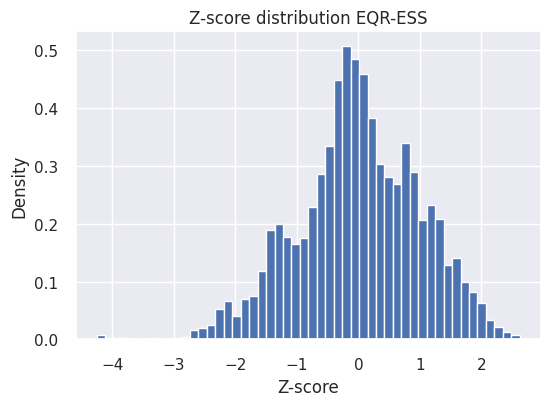


=== PAIR FITB - KEY  (corr = 0.893) ===


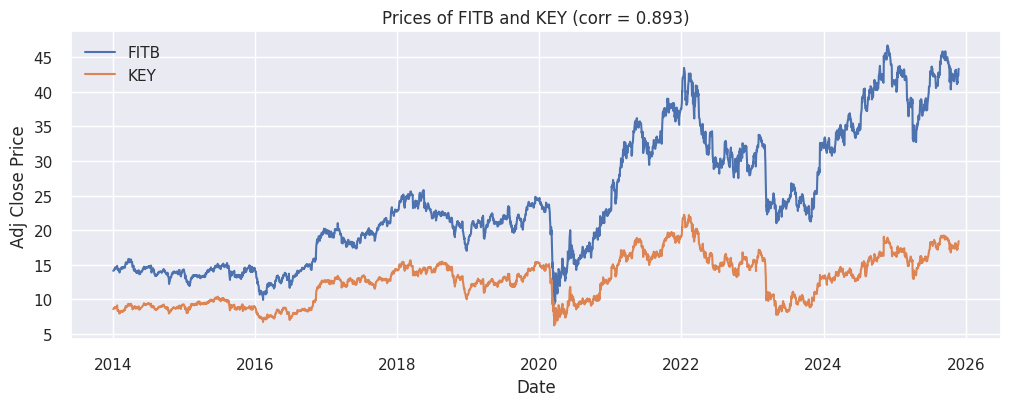

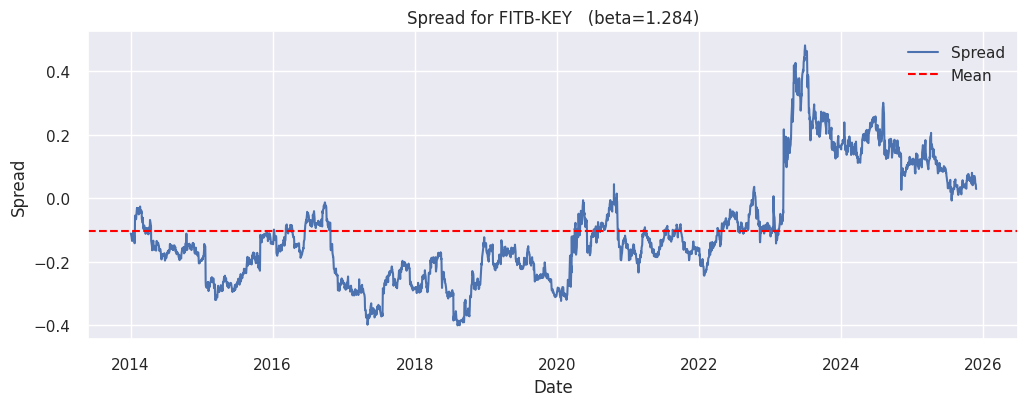

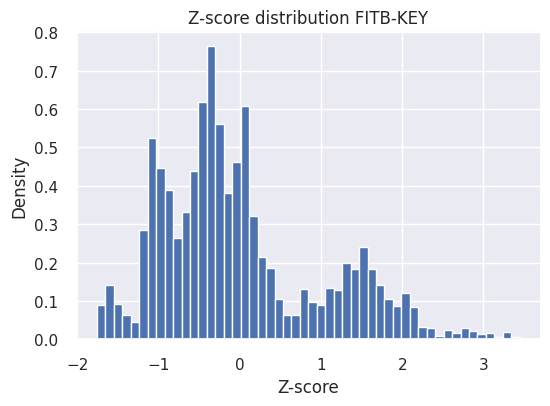


=== PAIR AVB - ESS  (corr = 0.889) ===


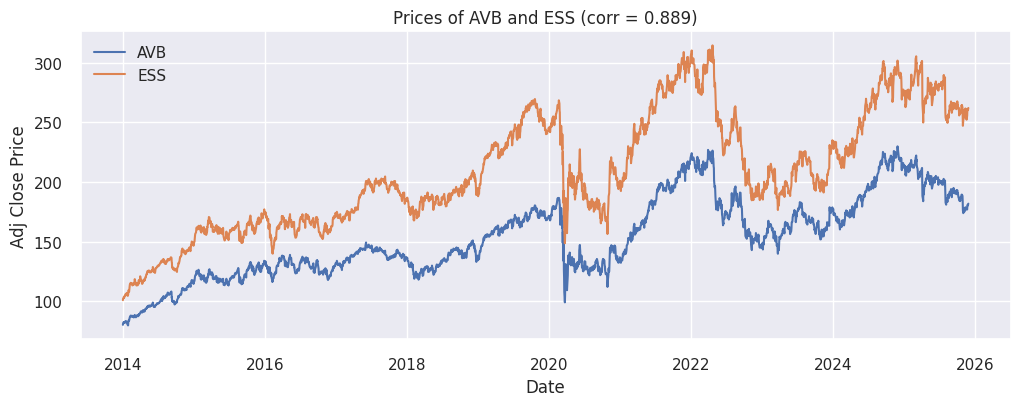

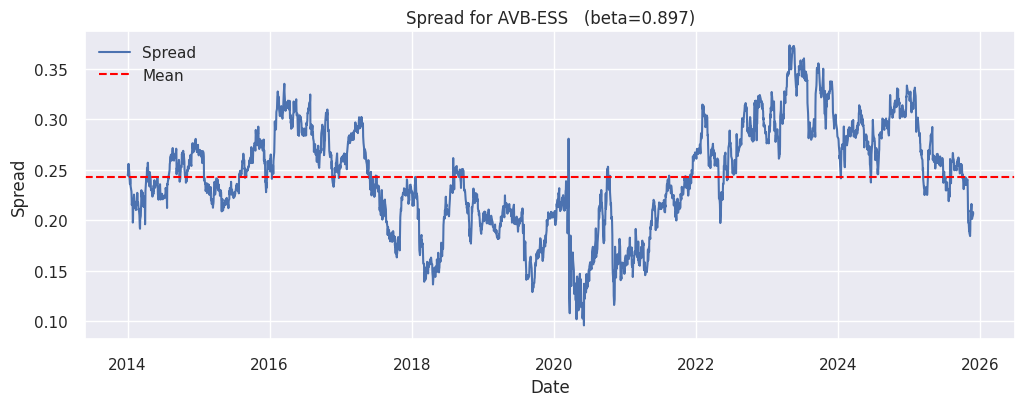

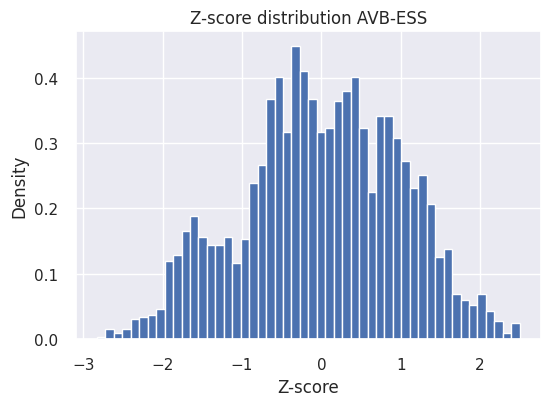


=== PAIR DHI - LEN  (corr = 0.889) ===


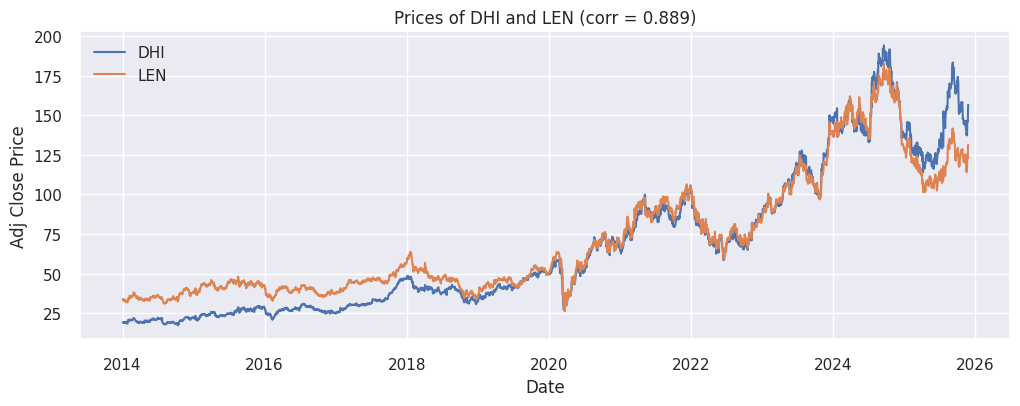

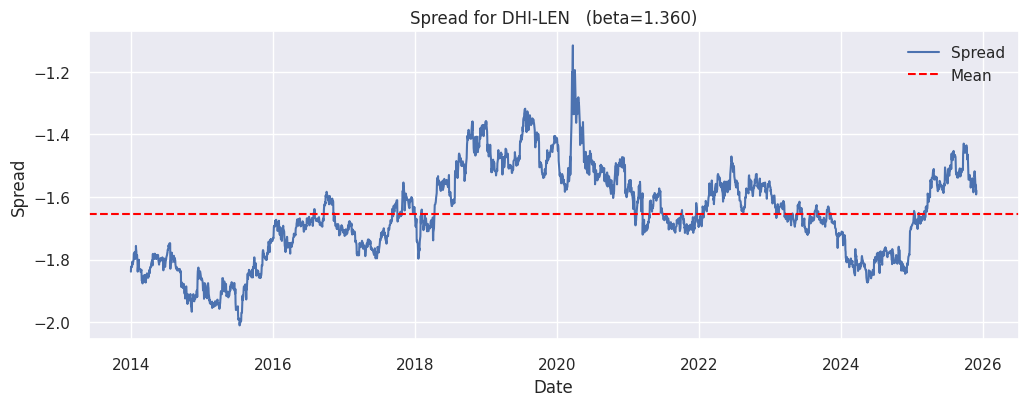

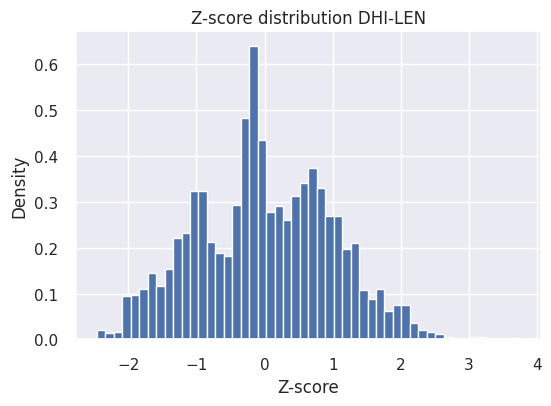


=== PAIR CFG - KEY  (corr = 0.889) ===


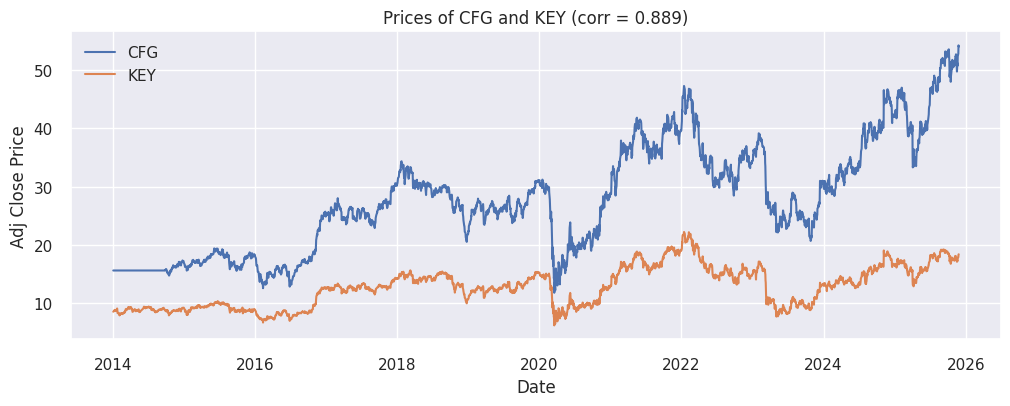

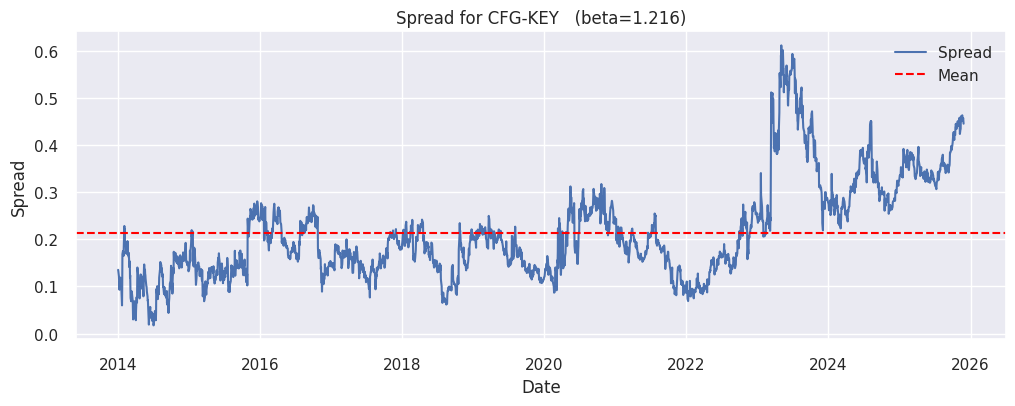

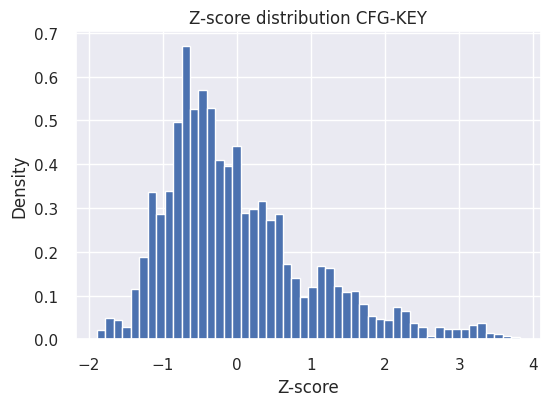


=== PAIR CMS - LNT  (corr = 0.889) ===


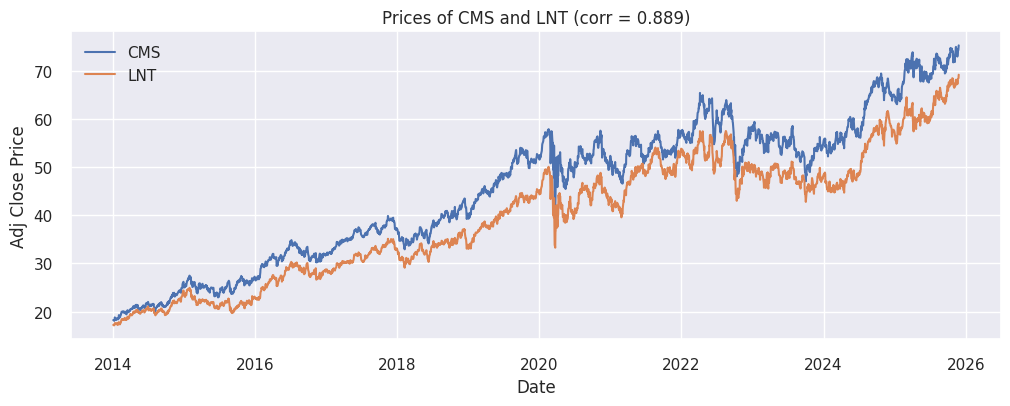

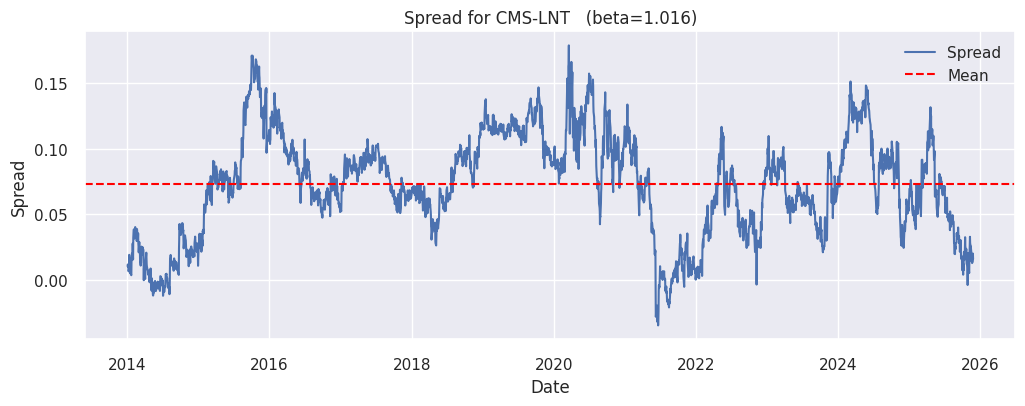

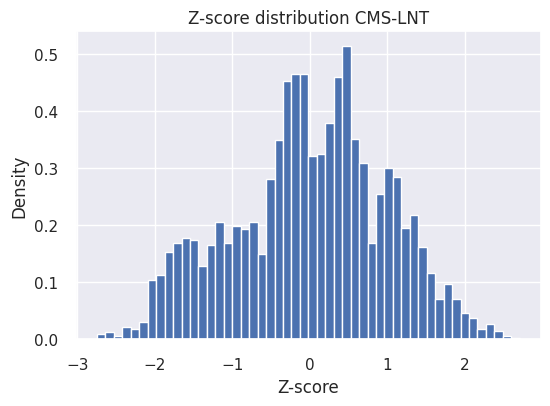


=== PAIR MA - V  (corr = 0.888) ===


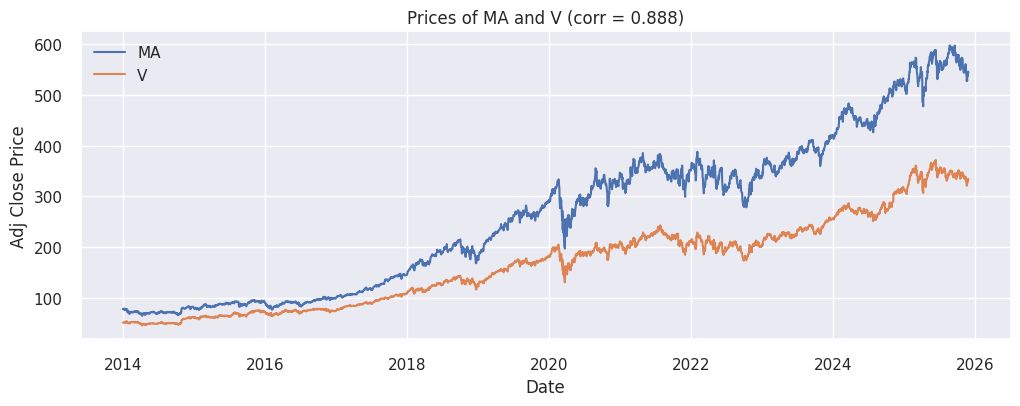

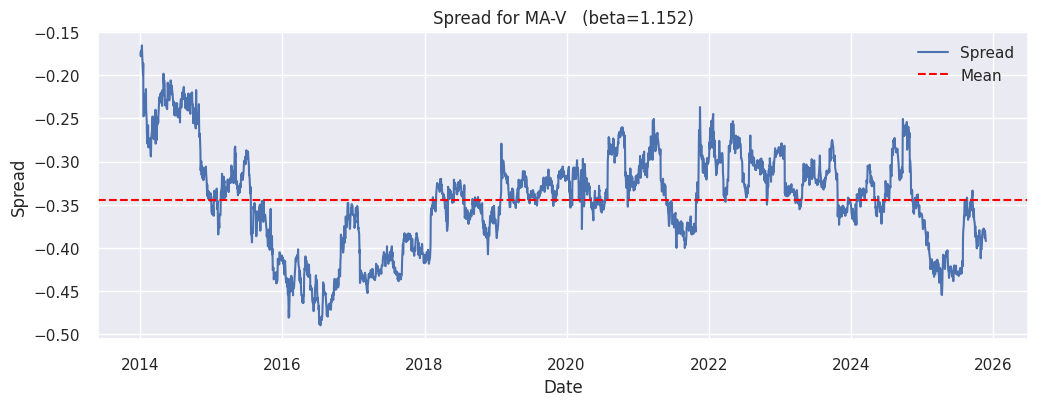

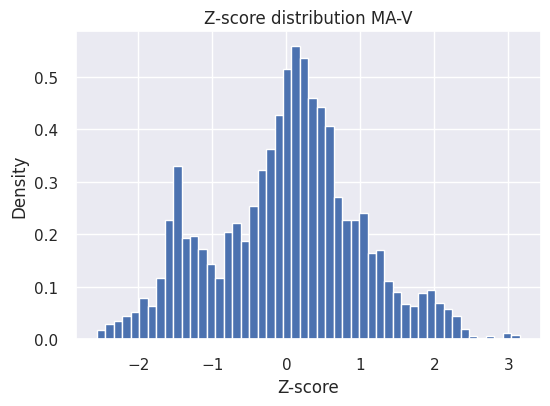


=== PAIR KEY - RF  (corr = 0.888) ===


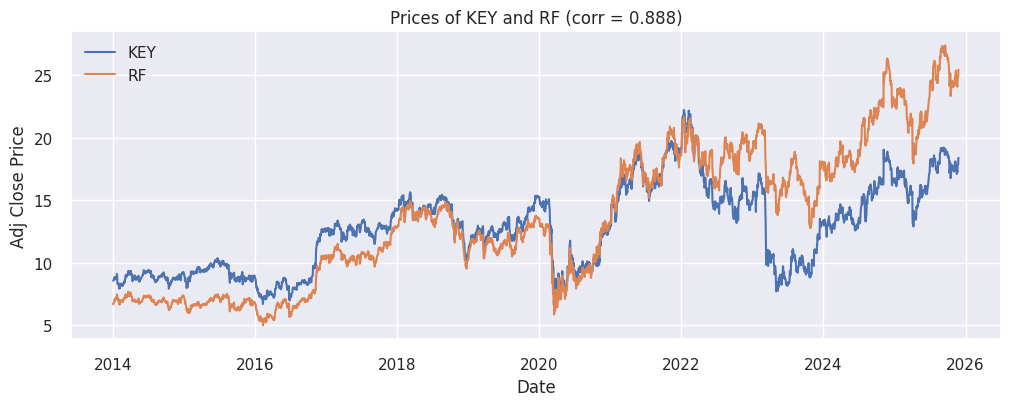

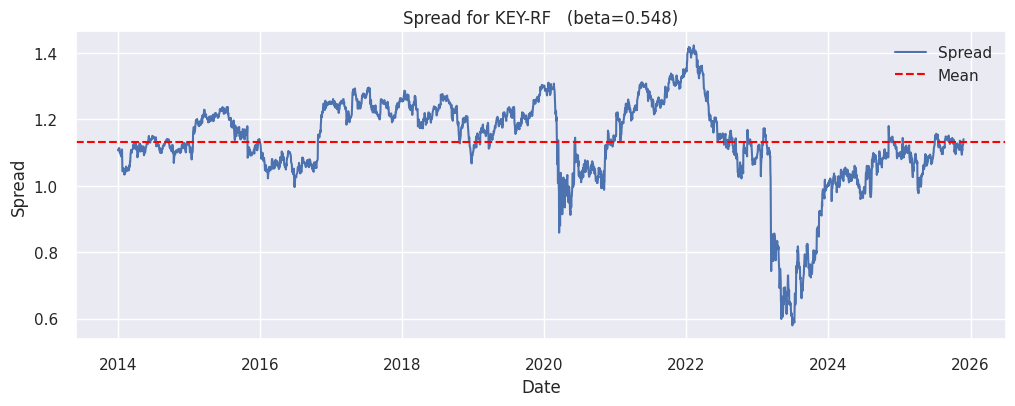

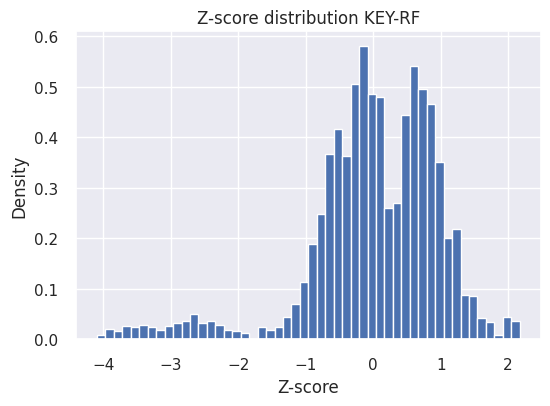


=== PAIR CFG - FITB  (corr = 0.888) ===


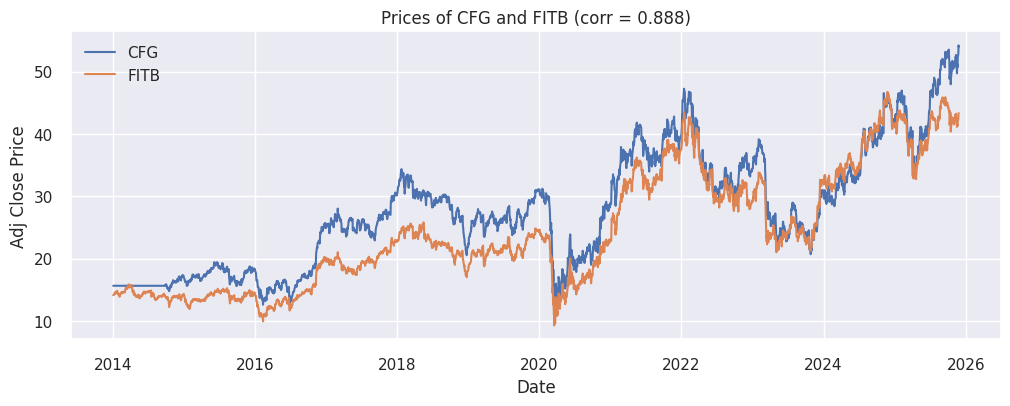

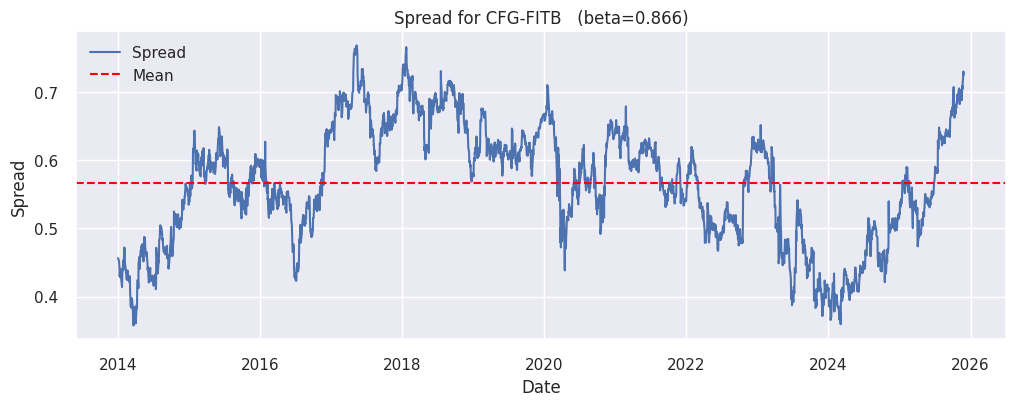

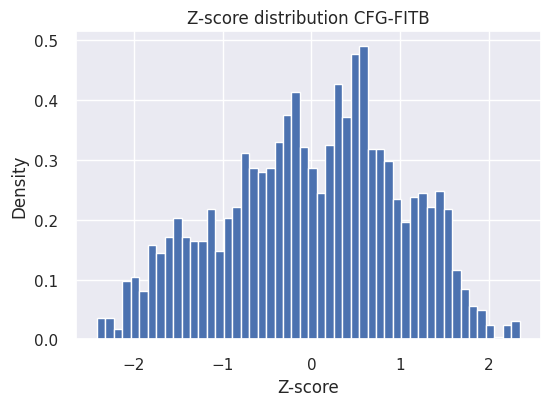


=== PAIR AMAT - LRCX  (corr = 0.886) ===


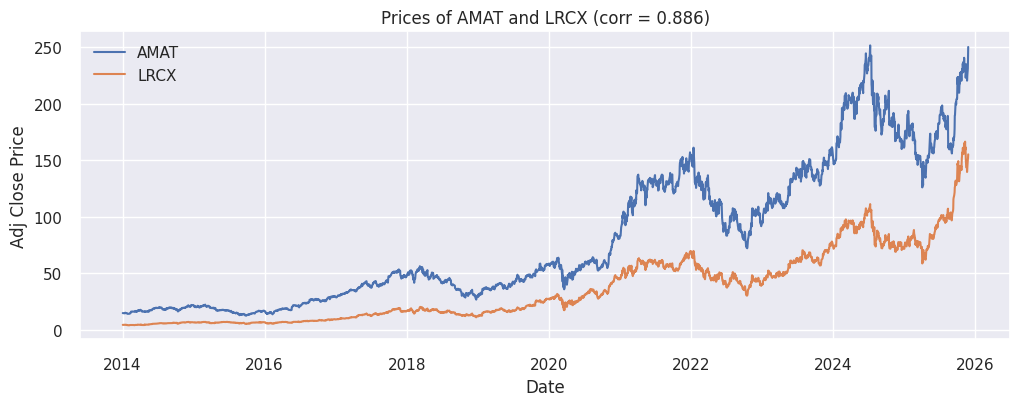

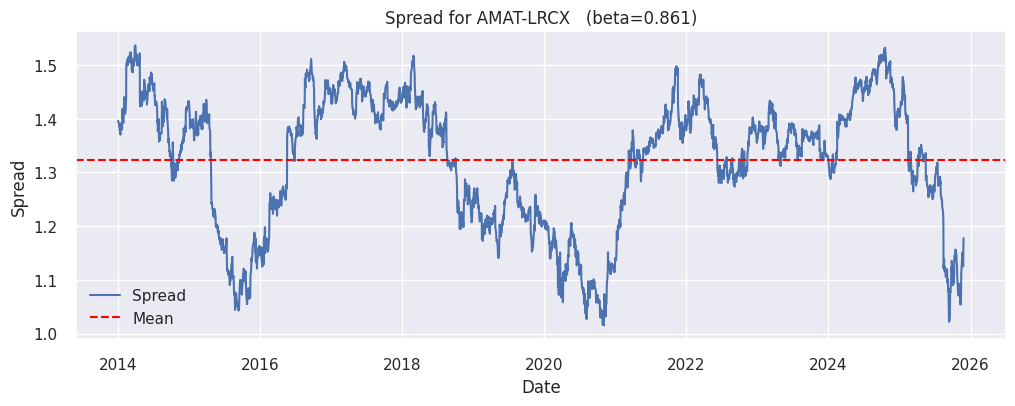

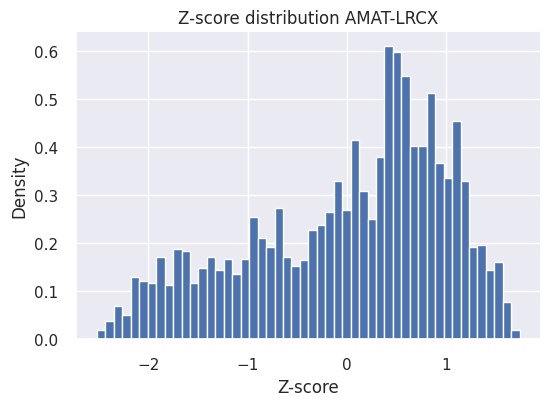


=== PAIR CMS - WEC  (corr = 0.884) ===


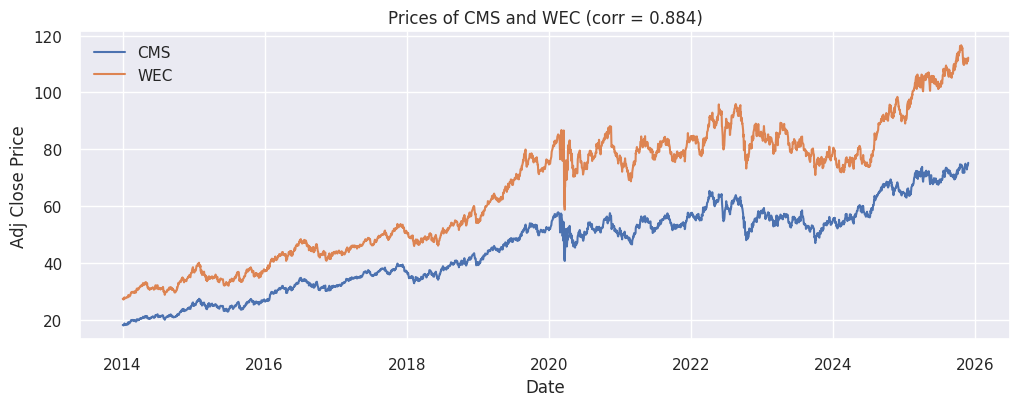

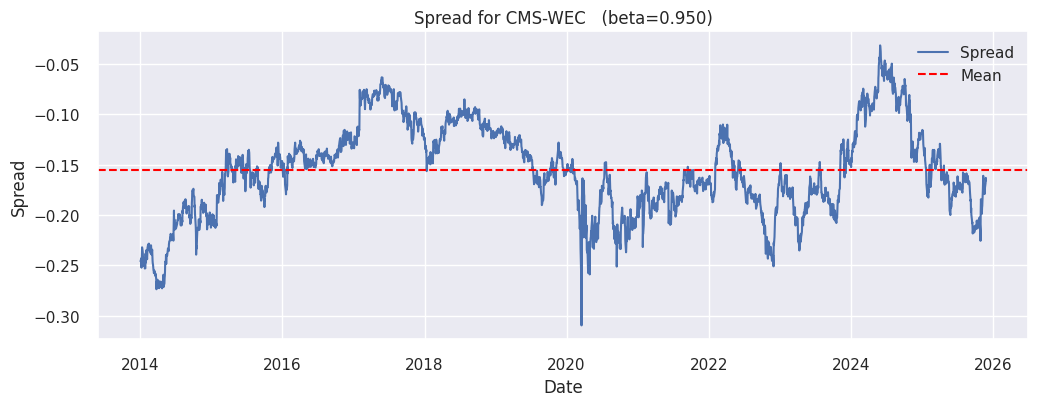

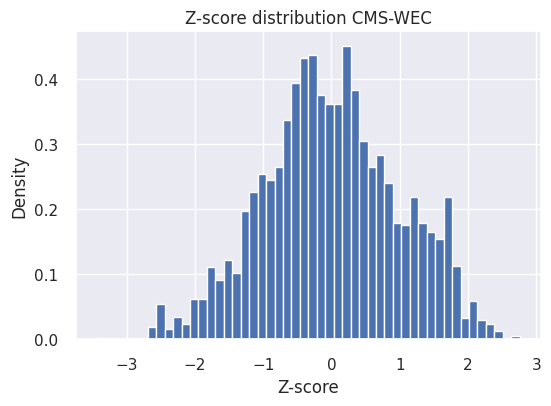


=== PAIR CFG - RF  (corr = 0.882) ===


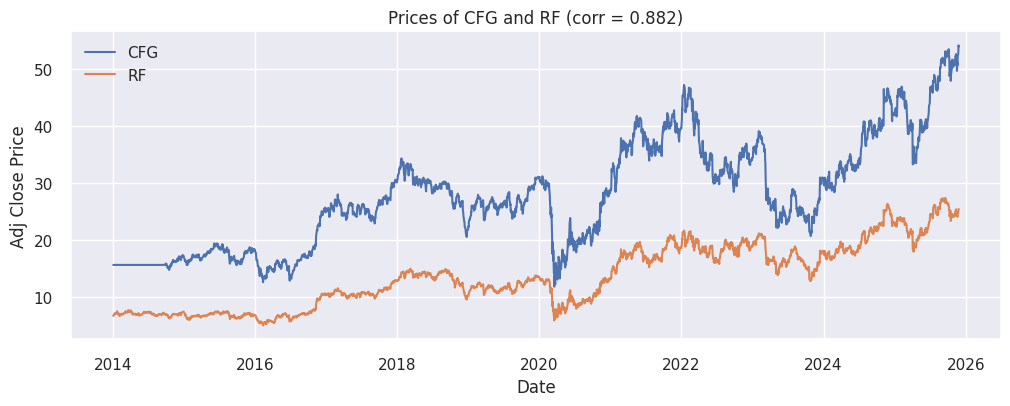

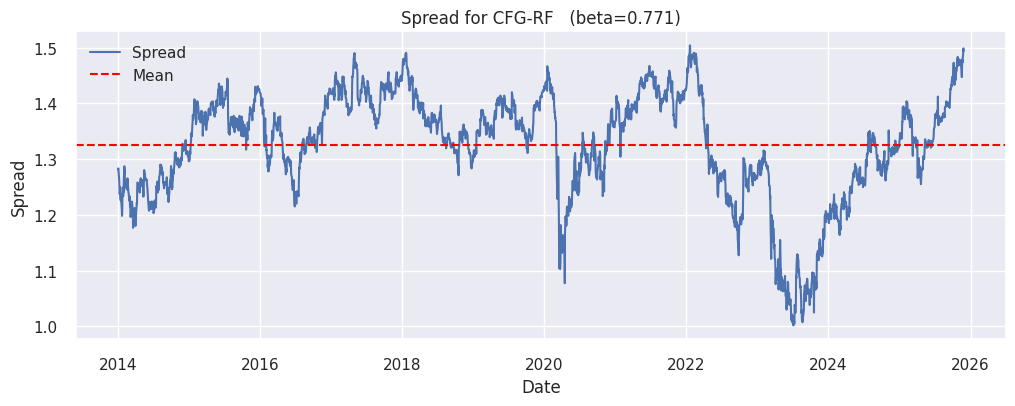

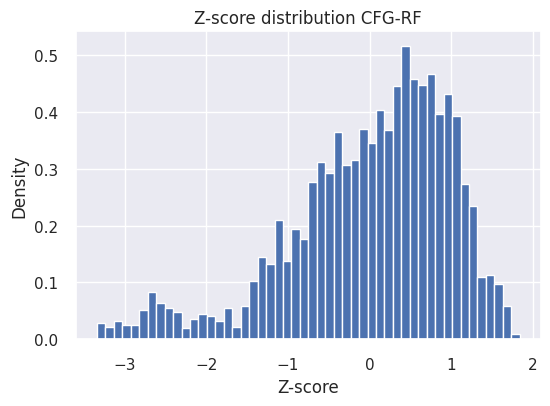


=== PAIR FITB - TFC  (corr = 0.882) ===


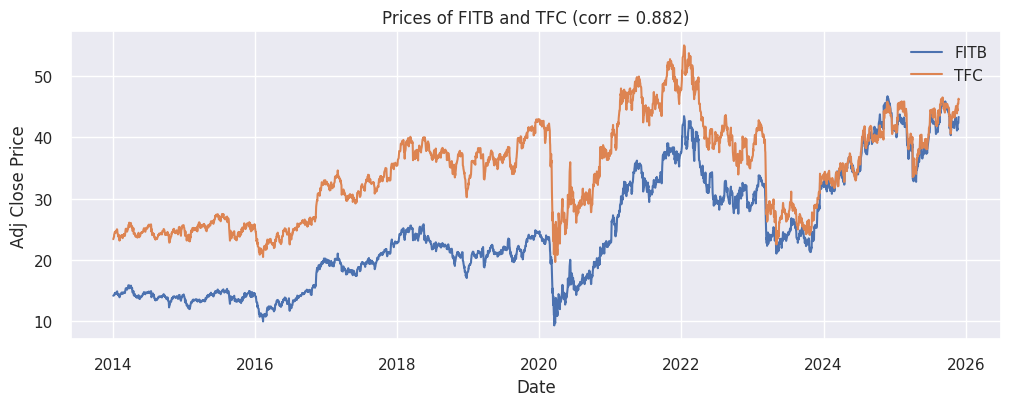

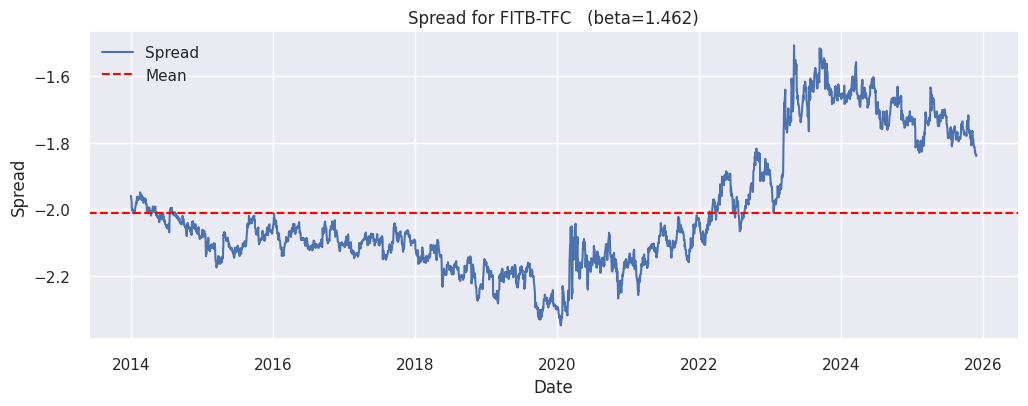

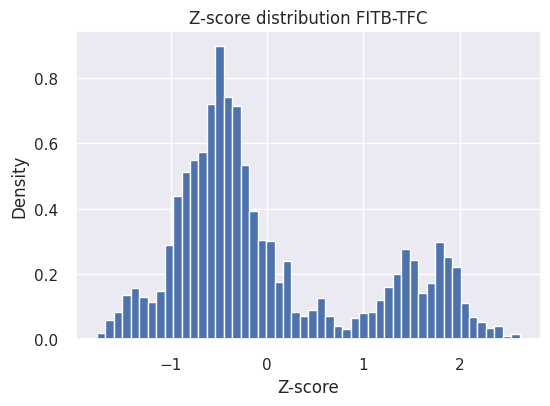

In [ ]:
# =========================================
# EDA AUTOMATISEE SUR 10 PAIRES (AMELIOREE)
# =========================================

from statsmodels.tsa.stattools import adfuller

eda_results = []

for (A, B, corr) in top20_pairs:

    print(f"\n=== PAIR {A} - {B}  (corr = {corr:.3f}) ===")

    # ============================
    # 1. Données de la paire
    # ============================
    df_pair = data[[A, B]].dropna()

    # ============================
    # 2. Graphique des prix des deux actifs
    # ============================
    plt.figure(figsize=(12,4))
    plt.plot(df_pair.index, df_pair[A], label=A)
    plt.plot(df_pair.index, df_pair[B], label=B)
    plt.title(f"Prices of {A} and {B} (corr = {corr:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Adj Close Price")
    plt.legend()
    plt.show()

    # ============================
    # 3. Calcul du spread OU
    # ============================
    logA = np.log(df_pair[A])
    logB = np.log(df_pair[B])

    beta = np.polyfit(logB, logA, 1)[0]
    spread = logA - beta*logB

    # ============================
    # 4. Statistiques du spread
    # ============================
    mean_sp = spread.mean()
    std_sp  = spread.std()
    skew_sp = spread.skew()
    kurt_sp = spread.kurt()

    # test ADF
    adf_pvalue = adfuller(spread.dropna())[1]

    # ============================
    # 5. Graphique du spread process
    # ============================
    plt.figure(figsize=(12,4))
    plt.plot(spread.index, spread, label="Spread")
    plt.axhline(mean_sp, color="red", linestyle="--", label="Mean")
    plt.title(f"Spread for {A}-{B}   (beta={beta:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Spread")
    plt.legend()
    plt.show()

    # ============================
    # 6. Z-score
    # ============================
    z = (spread - mean_sp) / std_sp

    # histogramme des z-scores
    plt.figure(figsize=(6,4))
    plt.hist(z.dropna(), bins=50, density=True)
    plt.title(f"Z-score distribution {A}-{B}")
    plt.xlabel("Z-score")
    plt.ylabel("Density")
    plt.show()

    # ============================
    # 7. Estimation half-life
    # ============================
    spread_lag = spread.shift(1).dropna()
    delta = spread.diff().dropna()

    beta_ou = np.polyfit(spread_lag, delta, 1)[0]
    theta = -np.log(1 + beta_ou)
    half_life = np.log(2) / theta if theta > 0 else np.nan

    # ============================
    # 8. Sauvegarde des résultats
    # ============================
    eda_results.append({
        "pair": f"{A}-{B}",
        "corr": corr,
        "beta": beta,
        "mean_spread": mean_sp,
        "std_spread": std_sp,
        "skew": skew_sp,
        "kurt": kurt_sp,
        "ADF_pvalue": adf_pvalue,
        "half_life": half_life
    })


In [ ]:
eda_df = pd.DataFrame(eda_results)
eda_df


pair      corr      beta  mean_spread  std_spread      skew  \
0     AVB-EQR  0.915361  1.063141     0.780074    0.046812 -0.049555   
1     EQR-UDR  0.913212  0.768724     1.333447    0.046715 -0.387195   
2     FRT-REG  0.912802  0.488085     2.615250    0.093210 -0.529202   
3     MET-PRU  0.904812  1.171627    -1.214637    0.120415 -0.579649   
4     FITB-RF  0.904653  0.879922     0.903005    0.077520 -0.710707   
5     AVB-UDR  0.901425  0.826680     2.165299    0.060130  0.140138   
6     ESS-UDR  0.894987  0.899993     2.215218    0.061004 -0.831332   
7     EQR-ESS  0.893959  0.829625    -0.428401    0.043266 -0.255544   
8    FITB-KEY  0.892738  1.283959    -0.102579    0.169563  0.846425   
9     AVB-ESS  0.889213  0.897375     0.242980    0.052100 -0.143982   
10    DHI-LEN  0.889082  1.360305    -1.656028    0.144049  0.065383   
11    CFG-KEY  0.888791  1.216490     0.214372    0.104176  1.112393   
12    CMS-LNT  0.888696  1.016124     0.072724    0.038982 -0.170343   
13       MA-V  0.888465  1.151877    -0.344574    0.056911 -0.036348   
14     KEY-RF  0.888319  0.547717     1.129821    0.134422 -1.307578   
15   CFG-FITB  0.887756  0.865931     0.565872    0.086182 -0.200310   
16  AMAT-LRCX  0.886386  0.861141     1.322934    0.122143 -0.585984   
17    CMS-WEC  0.884399  0.950465    -0.155463    0.044879 -0.012380   
18     CFG-RF  0.882204  0.770777     1.325581    0.096918 -0.949582   
19   FITB-TFC  0.882049  1.461887    -2.009892    0.191572  0.816217   

        kurt  ADF_pvalue   half_life  
0  -0.084878    0.054487   72.660378  
1   0.494203    0.017641   71.341252  
2  -0.604150    0.096425  117.862881  
3  -0.491231    0.183981  199.783445  
4   0.546456    0.040084   94.650100  
5  -0.365244    0.197387  122.700226  
6   1.544986    0.060398  116.227806  
7   0.158703    0.001216   57.997031  
8   0.149813    0.347521  178.743293  
9  -0.469889    0.030915   80.787293  
10 -0.399167    0.103427  127.484525  
11  1.172686    0.129729   83.909610  
12 -0.464214    0.016035   55.239736  
13 -0.176627    0.002023   60.008374  
14  2.833097    0.073247  117.285347  
15 -0.673143    0.075627   96.983754  
16 -0.638138    0.120028  161.064474  
17 -0.316773    0.029905   68.570695  
18  0.772867    0.060483  112.445345  
19 -0.490569    0.474364  255.268384

In [ ]:
def build_dataset_for_pair(A, B, H=7, window_mu=100, vol_window=20):
    """
    Construit le dataset ML pour une paire A-B :
    - spread OU
    - features avancées (directionnelles + vol/skew)
    - label = 1 si le trade OU (z-score) aurait été gagnant à horizon H
    """

    # 1) Données de base
    df_pair = data[[A, B]].dropna()

    if len(df_pair) < window_mu + H + 30:
        print(f"[WARN] Pair {A}-{B} has too few data: {len(df_pair)} rows. Skipping.")
        return pd.DataFrame()

    # 2) Log-prices
    logA = np.log(df_pair[A])
    logB = np.log(df_pair[B])

    # 3) Hedge-ratio beta (OLS statique)
    beta = np.polyfit(logB, logA, 1)[0]

    # 4) Spread OU
    spread = logA - beta * logB
    spread.name = "spread"

    # 5) Statistiques rolling pour z-score
    mu_roll = spread.rolling(window_mu).mean()
    sigma_roll = spread.rolling(window_mu).std()

    zscore = (spread - mu_roll) / sigma_roll
    spread_diff = spread.diff()
    spread_vol = spread.rolling(vol_window).std()

    # ============================
    # FEATURES DIRECTIONNELLES
    # ============================

    slope_5 = spread.diff().rolling(5).mean()
    slope_10 = spread.diff().rolling(10).mean()
    mr_speed = spread - spread.shift(5)
    acc_3 = spread.diff().diff().rolling(3).mean()

    abs_diff = spread.diff().abs()
    mean_abs_diff_20 = abs_diff.rolling(20).mean()
    jump = (abs_diff > mean_abs_diff_20).astype(int)

    # ============================
    # FEATURES VOL / SHAPE
    # ============================

    # Rendements des deux actifs réindexés sur spread.index
    retA = returns[A].reindex(spread.index)
    retB = returns[B].reindex(spread.index)

    vol_asset_a = retA.rolling(20).std()
    vol_asset_b = retB.rolling(20).std()
    vol_market = returns.rolling(20).std().mean(axis=1)  # vol moyenne du marché

    vol_ratio_a = vol_asset_a / vol_market
    vol_ratio_b = vol_asset_b / vol_market
    vol_spread_to_assets = spread_vol / (vol_asset_a + vol_asset_b)

    skew_20 = spread.rolling(20).skew()
    kurt_20 = spread.rolling(20).kurt()

    # ============================
    # HALF-LIFE / THETA (constantes par paire, mais on met en série)
    # ============================

    spread_lag = spread.shift(1).dropna()
    delta = spread.diff().dropna()

    if len(spread_lag) > 50:
        # Régression delta = b * spread_{t-1}
        b_ou = np.polyfit(spread_lag, delta, 1)[0]
        if b_ou > -1:
            theta = -np.log(1 + b_ou)
            if theta > 0:
                half_life = np.log(2) / theta
            else:
                theta = np.nan
                half_life = np.nan
        else:
            theta = np.nan
            half_life = np.nan
    else:
        theta = np.nan
        half_life = np.nan

    theta_series = pd.Series(theta, index=spread.index)
    half_life_series = pd.Series(half_life, index=spread.index)

    # ============================
    # LABEL = PnL DU TRADE OU
    # ============================

    future_spread = spread.shift(-H)
    future_return = future_spread - spread

    direction = -np.sign(zscore)  # OU: short si z > 0, long si z < 0
    ou_pnl = direction * future_return

    y = (ou_pnl > 0).astype(int)

    # ============================
    # CONSTRUCTION DU DATAFRAME
    # ============================

    features = pd.DataFrame({
        "spread": spread,
        "zscore": zscore,
        "abs_zscore": np.abs(zscore),
        "spread_diff": spread_diff,
        "spread_vol": spread_vol,
        "beta": beta,
        "slope_5": slope_5,
        "slope_10": slope_10,
        "mr_speed": mr_speed,
        "acc_3": acc_3,
        "jump": jump,
        "vol_ratio_a": vol_ratio_a,
        "vol_ratio_b": vol_ratio_b,
        "vol_spread_to_assets": vol_spread_to_assets,
        "skew_20": skew_20,
        "kurt_20": kurt_20,
        "theta": theta_series,
        "half_life": half_life_series
    })

    # Décalage d’un pas pour éviter le leakage
    features = features.shift(1)

    df = features.copy()
    df["ou_pnl"] = ou_pnl
    df["future_return"] = future_return
    df["y"] = y
    df["pair"] = f"{A}-{B}"

    df = df.dropna()

    print(f"[INFO] Pair {A}-{B}: {len(df)} samples after cleaning.")
    return df


In [ ]:
# =========================================
# 2. REBUILD DATASET ML MULTI-PAIRES
# =========================================
pairs_for_ml = [
    ("EQR", "ESS"),
    ("AMAT", "LRCX"),
    ("MET", "PRU"),
    ("FITB", "RF"),
    ("DHI", "LEN")
]


datasets = []
for A, B in pairs_for_ml:
    print(f"Building dataset for {A}-{B} ...")
    df_pair = build_dataset_for_pair(A, B, H=15)   # <= H=5 conseillé ici
    if len(df_pair) > 0:
        datasets.append(df_pair)

df_ml = pd.concat(datasets, axis=0)
df_ml = df_ml.sort_index()

print("df_ml shape:", df_ml.shape)
df_ml.head()


Building dataset for EQR-ESS ...
[INFO] Pair EQR-ESS: 2880 samples after cleaning.
Building dataset for AMAT-LRCX ...
[INFO] Pair AMAT-LRCX: 2880 samples after cleaning.
Building dataset for MET-PRU ...
[INFO] Pair MET-PRU: 2880 samples after cleaning.
Building dataset for FITB-RF ...
[INFO] Pair FITB-RF: 2880 samples after cleaning.
Building dataset for DHI-LEN ...
[INFO] Pair DHI-LEN: 2880 samples after cleaning.
df_ml shape: (14400, 22)


spread    zscore  abs_zscore  spread_diff  spread_vol      beta  \
Date                                                                            
2014-05-28 -0.444141 -0.151482    0.151482     0.007421    0.004686  0.829625   
2014-05-28  0.946854 -0.447239    0.447239     0.003401    0.006825  0.879922   
2014-05-28  1.448310 -0.257780    0.257780     0.009706    0.013128  0.861141   
2014-05-28 -1.816271  0.135846    0.135846    -0.016494    0.008007  1.360305   
2014-05-28 -1.160273  0.513623    0.513623    -0.004124    0.014478  1.171627   

             slope_5  slope_10  mr_speed     acc_3  ...  vol_ratio_b  \
Date                                                ...                
2014-05-28 -0.000951 -0.000930 -0.004755  0.003591  ...     0.504012   
2014-05-28  0.003318  0.002462  0.016591 -0.000473  ...     0.949704   
2014-05-28 -0.002642  0.000934 -0.013209  0.004022  ...     1.265913   
2014-05-28 -0.004328 -0.001835 -0.021640 -0.005435  ...     1.255461   
2014-05-28 -0.001184  0.000716 -0.005922 -0.002144  ...     1.222567   

            vol_spread_to_assets   skew_20   kurt_20     theta   half_life  \
Date                                                                         
2014-05-28              0.381455 -0.273562 -0.154381  0.011951   57.997031   
2014-05-28              0.299019  0.490746 -0.373636  0.007323   94.650100   
2014-05-28              0.353777  0.473774 -0.184620  0.004304  161.064474   
2014-05-28              0.226680 -1.363118  3.190285  0.005437  127.484525   
2014-05-28              0.467038  1.360455  1.991524  0.003469  199.783445   

              ou_pnl  future_return  y       pair  
Date                                               
2014-05-28 -0.000881      -0.000881  0    EQR-ESS  
2014-05-28 -0.015007      -0.015007  0    FITB-RF  
2014-05-28  0.018624       0.018624  1  AMAT-LRCX  
2014-05-28  0.030224      -0.030224  1    DHI-LEN  
2014-05-28  0.015178      -0.015178  1    MET-PRU  

[5 rows x 22 columns]

In [ ]:
# ===============================
# SPLIT TEMPOREL POUR LE ML
# ===============================

X = df_ml.drop(columns=["y", "pair", "ou_pnl", "future_return"])
y = df_ml["y"]

split = int(0.7 * len(df_ml))
print("Split index:", split)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

df_train = df_ml.iloc[:split].copy()
df_test  = df_ml.iloc[split:].copy()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Split index: 10080
X_train shape: (10080, 18)
X_test shape: (4320, 18)


In [ ]:
# =========================================
# BASELINE LOGISTIC REGRESSION
# =========================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

pipe_logit = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42   # ← juste pour reproductibilité
    ))
])

pipe_logit.fit(X_train, y_train)

y_pred = pipe_logit.predict(X_test)
y_prob = pipe_logit.predict_proba(X_test)[:, 1]

print("=== BASELINE LOGISTIC REGRESSION ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))


=== BASELINE LOGISTIC REGRESSION ===
Accuracy: 0.5402777777777777
AUC: 0.5516588497926801

Classification report:
               precision    recall  f1-score   support

           0       0.51      0.50      0.50      2019
           1       0.57      0.58      0.57      2301

    accuracy                           0.54      4320
   macro avg       0.54      0.54      0.54      4320
weighted avg       0.54      0.54      0.54      4320



In [ ]:
# =========================================
# GRIDSEARCHCV ON LOGISTIC REGRESSION
# =========================================

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "logit__C": [0.01, 0.1, 1, 10],
    "logit__penalty": ["l2"],
    "logit__solver": ["lbfgs"]
}

grid_logit = GridSearchCV(
    pipe_logit,
    param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1
)

grid_logit.fit(X_train, y_train)

print("=== BEST LOGISTIC REGRESSION PARAMETERS ===")
print(grid_logit.best_params_)

# On récupère le meilleur pipeline (scaler + logit réglé)
best_logit = grid_logit.best_estimator_

# Predictions
y_pred = best_logit.predict(X_test)
y_prob = best_logit.predict_proba(X_test)[:, 1]

print("\n=== GRIDSEARCH LOGIT PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))


=== BEST LOGISTIC REGRESSION PARAMETERS ===
{'logit__C': 0.01, 'logit__penalty': 'l2', 'logit__solver': 'lbfgs'}

=== GRIDSEARCH LOGIT PERFORMANCE ===
Accuracy: 0.5303240740740741
AUC: 0.5509289304841727

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      2019
           1       0.56      0.54      0.55      2301

    accuracy                           0.53      4320
   macro avg       0.53      0.53      0.53      4320
weighted avg       0.53      0.53      0.53      4320



In [ ]:
y_pred_proba_train = grid_logit.predict_proba(X_train)[:, 1]
y_pred_proba_test = grid_logit.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_pred_proba_train)
auc_test = roc_auc_score(y_test, y_pred_proba_test)

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test:  {auc_test:.4f}")
print(f"Écart: {auc_train - auc_test:.4f}")

AUC Train: 0.5609
AUC Test:  0.5509
Écart: 0.0099


In [ ]:
# =========================================
# RANDOM FOREST (RÉGULARISÉ)
# =========================================

from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=4,          # on garde 4, déjà raisonnable
        min_samples_leaf=100, # 50 -> 100 : feuilles plus grosses = moins d’overfit
        min_samples_split=50, # on ajoute une contrainte pour éviter de splitter trop
        max_features='sqrt',  # sous-échantillonne les features à chaque split
        class_weight="balanced",
        random_state=42,
        n_jobs=-1             # parallélisation + reproductible
    ))
])

pipe_rf.fit(X_train, y_train)

y_pred_rf = pipe_rf.predict(X_test)
y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]

print("=== RANDOM FOREST PERFORMANCE (REG) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))


=== RANDOM FOREST PERFORMANCE (REG) ===
Accuracy: 0.531712962962963
AUC: 0.5580195444451117

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      2019
           1       0.56      0.56      0.56      2301

    accuracy                           0.53      4320
   macro avg       0.53      0.53      0.53      4320
weighted avg       0.53      0.53      0.53      4320



In [ ]:
# =========================================
# VOTING CLASSIFIER (ENSEMBLE RÉGULARISÉ)
# =========================================

from sklearn.ensemble import VotingClassifier

# Si tu as suivi ma modif de la cellule GridSearch :
# best_logit = grid_logit.best_estimator_
# et pipe_rf est ton RF régularisé défini juste avant

voting_clf_v2 = VotingClassifier(
    estimators=[
        ("logit", best_logit),  # ou grid_logit.best_estimator_ si tu n'as pas créé best_logit
        ("rf", pipe_rf)
    ],
    voting="soft"
)

voting_clf_v2.fit(X_train, y_train)

# Prédictions test
y_pred_v = voting_clf_v2.predict(X_test)
y_prob_v = voting_clf_v2.predict_proba(X_test)[:, 1]

# AUC train / test pour checker l'overfitting
y_prob_train_v = voting_clf_v2.predict_proba(X_train)[:, 1]
auc_train_v = roc_auc_score(y_train, y_prob_train_v)
auc_test_v  = roc_auc_score(y_test, y_prob_v)
gap_v = auc_train_v - auc_test_v

print("=== VOTING CLASSIFIER PERFORMANCE (REG) ===")
print(f"AUC train : {auc_train_v:.4f}")
print(f"AUC test  : {auc_test_v:.4f}")
print(f"Gap       : {gap_v:.4f} ({gap_v*100:.2f}%)\n")

print("Accuracy:", accuracy_score(y_test, y_pred_v))
print("\nClassification report:\n", classification_report(y_test, y_pred_v))


=== VOTING CLASSIFIER PERFORMANCE (REG) ===
AUC train : 0.5978
AUC test  : 0.5546
Gap       : 0.0432 (4.32%)

Accuracy: 0.5328703703703703

Classification report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      2019
           1       0.56      0.54      0.55      2301

    accuracy                           0.53      4320
   macro avg       0.53      0.53      0.53      4320
weighted avg       0.53      0.53      0.53      4320



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    grid_logit.best_estimator_,
    X_train, y_train,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='roc_auc'
)

print(f"AUC CV folds: {scores}")
print(f"Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")

AUC CV folds: [0.51089195 0.49993165 0.53725593 0.53500145 0.55265001]
Mean: 0.5271, Std: 0.0191


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    grid_logit.best_estimator_, X_test, y_test,
    n_repeats=10, scoring='roc_auc'
)

# Si quelques features dominent → possible overfitting
# Si toutes les features ≈ 0 → modèle faible
for name, imp in zip(X.columns, result.importances_mean):
    print(f"{name}: {imp:.4f}")

spread: -0.0037
zscore: 0.0046
abs_zscore: 0.0274
spread_diff: 0.0006
spread_vol: -0.0017
beta: -0.0005
slope_5: 0.0002
slope_10: 0.0013
mr_speed: 0.0002
acc_3: -0.0003
jump: -0.0006
vol_ratio_a: 0.0003
vol_ratio_b: 0.0084
vol_spread_to_assets: 0.0049
skew_20: -0.0004
kurt_20: 0.0021
theta: 0.0089
half_life: -0.0012


In [ ]:
models_results = {
    "Baseline Logit": roc_auc_score(y_test, pipe_logit.predict_proba(X_test)[:,1]),
    "Grid Logit": roc_auc_score(y_test, grid_logit.predict_proba(X_test)[:,1]),
    "Random Forest": roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:,1]),
    "Voting": roc_auc_score(y_test, voting_clf_v2.predict_proba(X_test)[:,1])
}

models_results


{'Baseline Logit': np.float64(0.5516588497926801),
 'Grid Logit': np.float64(0.5509289304841727),
 'Random Forest': np.float64(0.5580195444451117),
 'Voting': np.float64(0.5546478381494877)}

AUC Voting v2: 0.5546478381494877

Poids risk-parity (classiques) :
pair
AMAT-LRCX    0.164416
DHI-LEN      0.134654
EQR-ESS      0.294667
FITB-RF      0.227770
MET-PRU      0.178492
Name: ou_pnl, dtype: float64

=== PERFORMANCE PORTFEUILLE (TEST) ===
Sharpe OU seul      : 1.488
Sharpe OU + ML      : 1.976
Nb trades OU seul   : 521
Nb trades OU + ML   : 375
PNL final OU seul   : 0.9532
PNL final OU + ML   : 1.0850


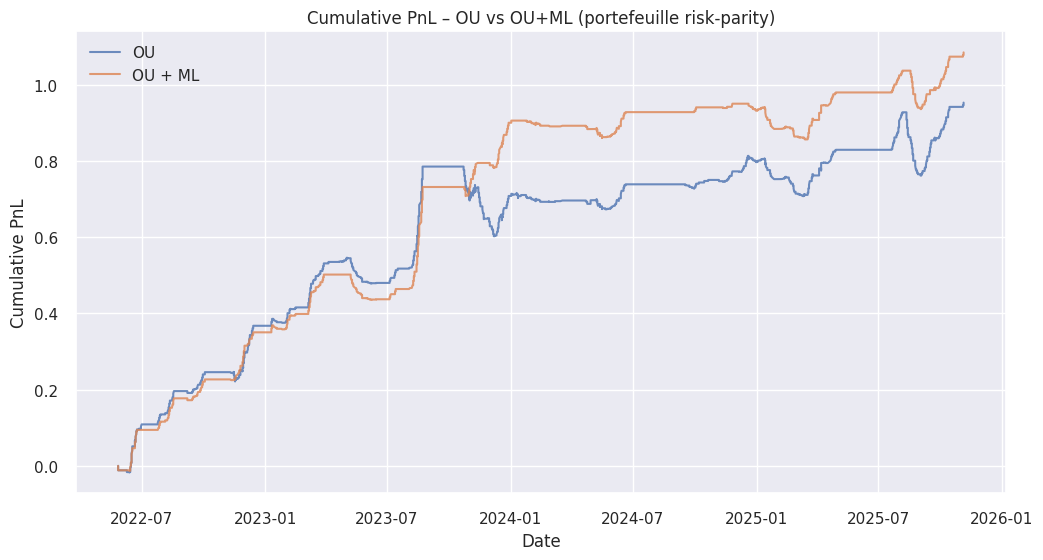

In [ ]:
# ============================================
# BACKTEST COMPLET OU vs OU+ML (risk-parity classique)
# ============================================

from sklearn.metrics import roc_auc_score

# 0) Probabilités ML sur la zone de test
#    -> on choisit Voting v2 comme modèle final (si tu préfères grid_logit ou pipe_xgb, change juste cette ligne)
df_test["y_prob"] = voting_clf_v2.predict_proba(X_test)[:, 1]

print("AUC Voting v2:", roc_auc_score(y_test, df_test["y_prob"]))

# 1) Paramètres de stratégie
z_entry = 2
prob_thresh = 0.54

# 2) Signaux de trading
df_test["trade_ou"] = (df_test["zscore"].abs() > z_entry).astype(int)

df_test["trade_ml"] = (
    (df_test["zscore"].abs() > z_entry) &
    (df_test["y_prob"] > prob_thresh)
).astype(int)

# 3) PnL par trade (par paire)
# ou_pnl = PnL théorique du trade OU (calculé dans build_dataset_for_pair)
df_test["pnl_ou"] = df_test["trade_ou"] * df_test["ou_pnl"]
df_test["pnl_ml"] = df_test["trade_ml"] * df_test["ou_pnl"]

# 4) Poids risk-parity classiques (calculés sur la période TRAIN)
train_vol = df_train.groupby("pair")["ou_pnl"].std()
inv_vol = 1.0 / train_vol
weights = inv_vol / inv_vol.sum()

print("\nPoids risk-parity (classiques) :")
print(weights)

# On applique les poids aux jeux train/test (utile si tu veux regarder train aussi)
df_train["weight"] = df_train["pair"].map(weights)
df_test["weight"]  = df_test["pair"].map(weights)

# 5) PnL portefeuille (somme pondérée des paires)
df_test["pnl_ou_port"] = df_test["pnl_ou"] * df_test["weight"]
df_test["pnl_ml_port"] = df_test["pnl_ml"] * df_test["weight"]

df_test["cum_pnl_ou"] = df_test["pnl_ou_port"].cumsum()
df_test["cum_pnl_ml"] = df_test["pnl_ml_port"].cumsum()

# 6) Fonctions utilitaires pour Sharpe
def sharpe_ratio(pnl_series, periods_per_year=252):
    ret_mean = pnl_series.mean()
    ret_std  = pnl_series.std()
    if ret_std == 0:
        return 0.0
    return np.sqrt(periods_per_year) * ret_mean / ret_std

sharpe_ou = sharpe_ratio(df_test["pnl_ou_port"])
sharpe_ml = sharpe_ratio(df_test["pnl_ml_port"])

pnl_ou_final = df_test["cum_pnl_ou"].iloc[-1]
pnl_ml_final = df_test["cum_pnl_ml"].iloc[-1]

nb_trades_ou = df_test["trade_ou"].sum()
nb_trades_ml = df_test["trade_ml"].sum()

print("\n=== PERFORMANCE PORTFEUILLE (TEST) ===")
print(f"Sharpe OU seul      : {sharpe_ou:.3f}")
print(f"Sharpe OU + ML      : {sharpe_ml:.3f}")
print(f"Nb trades OU seul   : {nb_trades_ou}")
print(f"Nb trades OU + ML   : {nb_trades_ml}")
print(f"PNL final OU seul   : {pnl_ou_final:.4f}")
print(f"PNL final OU + ML   : {pnl_ml_final:.4f}")

# 7) Plot des PnL cumulés
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, df_test["cum_pnl_ou"], label="OU", alpha=0.8)
plt.plot(df_test.index, df_test["cum_pnl_ml"], label="OU + ML", alpha=0.8)
plt.title("Cumulative PnL – OU vs OU+ML (portefeuille risk-parity)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.show()


In [ ]:
# =========================================
# 5. METRIQUES DE PERFORMANCE
# =========================================

def sharpe_ratio(pnl_series, periods_per_year=252):
    mu = pnl_series.mean()
    sigma = pnl_series.std()
    if sigma == 0:
        return 0.0
    return (mu / sigma) * np.sqrt(periods_per_year)

sharpe_ou = sharpe_ratio(df_test["pnl_ou_port"])
sharpe_ml = sharpe_ratio(df_test["pnl_ml_port"])

n_trades_ou = df_test["trade_ou"].sum()
n_trades_ml = df_test["trade_ml"].sum()

pnl_final_ou = df_test["cum_pnl_ou"].iloc[-1]
pnl_final_ml = df_test["cum_pnl_ml"].iloc[-1]

print("=== PERFORMANCE PORTFEUILLE (TEST) ===")
print(f"Sharpe OU seul      : {sharpe_ou:.3f}")
print(f"Sharpe OU + ML      : {sharpe_ml:.3f}")
print(f"Nb trades OU seul   : {n_trades_ou}")
print(f"Nb trades OU + ML   : {n_trades_ml}")
print(f"PNL final OU seul   : {pnl_final_ou:.4f}")
print(f"PNL final OU + ML   : {pnl_final_ml:.4f}")


=== PERFORMANCE PORTFEUILLE (TEST) ===
Sharpe OU seul      : 1.488
Sharpe OU + ML      : 1.976
Nb trades OU seul   : 521
Nb trades OU + ML   : 375
PNL final OU seul   : 0.9532
PNL final OU + ML   : 1.0850


In [ ]:
perf_by_pair = df_test.groupby("pair")[["pnl_ou", "pnl_ml"]].sum()
print("\nPnL total par paire (OU vs OU+ML) :")
print(perf_by_pair)



PnL total par paire (OU vs OU+ML) :
             pnl_ou    pnl_ml
pair                         
AMAT-LRCX -0.164662 -0.480329
DHI-LEN    1.496022  1.291071
EQR-ESS    1.561697  1.529511
FITB-RF    0.748436  1.701250
MET-PRU    0.829988  0.850965


In [ ]:
# Comparer train vs test
from sklearn.metrics import roc_auc_score

y_prob_train = voting_clf_v2.predict_proba(X_train)[:, 1]
y_prob_test = voting_clf_v2.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

print(f"AUC Train: {auc_train:.4f}")
print(f"AUC Test:  {auc_test:.4f}")
print(f"Gap: {auc_train - auc_test:.4f}")

# ✅ BON: écart < 0.05
# ⚠️ MAUVAIS: écart > 0.10

AUC Train: 0.5978
AUC Test:  0.5546
Gap: 0.0432


In [ ]:
# Win-rate des trades acceptés vs filtrés
df_accepted = df_test[df_test["trade_ml"] == 1]
df_filtered_out = df_test[(df_test["trade_ou"] == 1) & (df_test["trade_ml"] == 0)]

print("=== TRADES ACCEPTÉS ===")
print(f"Nombre: {len(df_accepted)}")
print(f"Win-rate: {(df_accepted['ou_pnl'] > 0).sum() / len(df_accepted):.2%}")
print(f"PnL moyen: {df_accepted['ou_pnl'].mean():.6f}")
print(f"PnL total: {df_accepted['ou_pnl'].sum():.4f}")

print("\n=== TRADES FILTRÉS ===")
print(f"Nombre: {len(df_filtered_out)}")
print(f"Win-rate: {(df_filtered_out['ou_pnl'] > 0).sum() / len(df_filtered_out):.2%}")
print(f"PnL moyen: {df_filtered_out['ou_pnl'].mean():.6f}")
print(f"PnL total: {df_filtered_out['ou_pnl'].sum():.4f}")

# Ratio de qualité
print(f"\nRatio win-rate (acceptés / filtrés): {(df_accepted['ou_pnl'] > 0).sum() / len(df_accepted) / ((df_filtered_out['ou_pnl'] > 0).sum() / len(df_filtered_out)):.3f}")

=== TRADES ACCEPTÉS ===
Nombre: 375
Win-rate: 69.60%
PnL moyen: 0.013047
PnL total: 4.8925

=== TRADES FILTRÉS ===
Nombre: 146
Win-rate: 50.68%
PnL moyen: -0.002883
PnL total: -0.4210

Ratio win-rate (acceptés / filtrés): 1.373


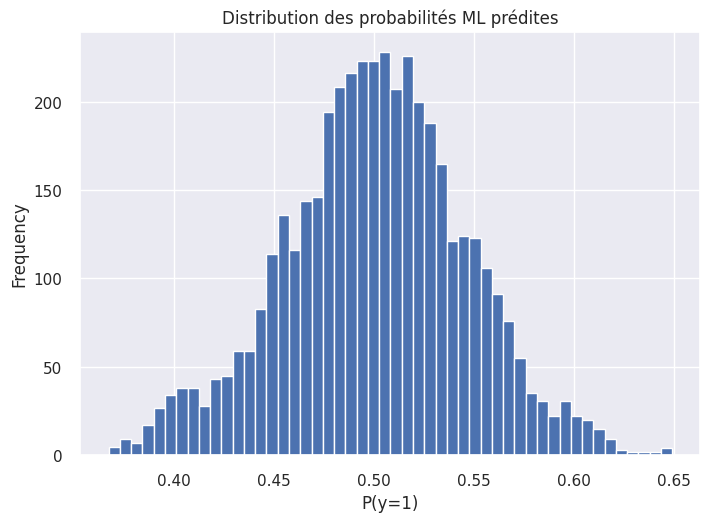

Proba moyenne: 0.5005
Proba médiane: 0.5013
Proba min: 0.3674
Proba max: 0.6491


In [ ]:
df_test["y_prob"].hist(bins=50)
plt.title("Distribution des probabilités ML prédites")
plt.xlabel("P(y=1)")
plt.ylabel("Frequency")
plt.show()

print(f"Proba moyenne: {df_test['y_prob'].mean():.4f}")
print(f"Proba médiane: {df_test['y_prob'].median():.4f}")
print(f"Proba min: {df_test['y_prob'].min():.4f}")
print(f"Proba max: {df_test['y_prob'].max():.4f}")

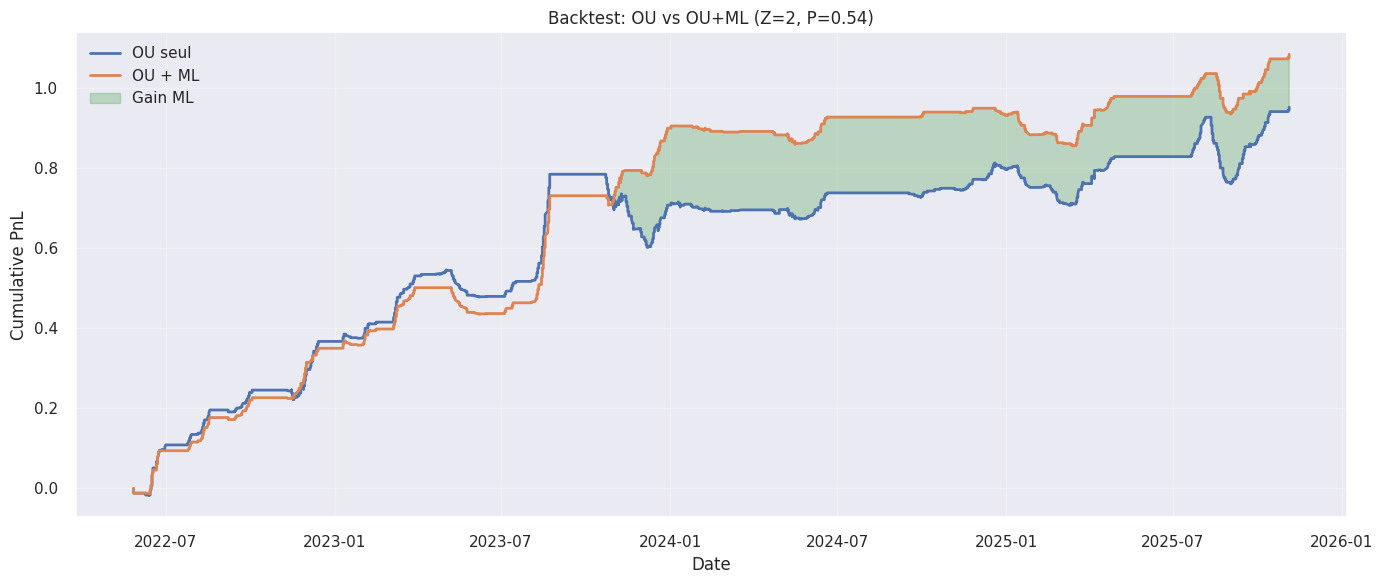

In [ ]:
df_test["cum_pnl_ou"] = df_test["pnl_ou_port"].cumsum()
df_test["cum_pnl_ml"] = df_test["pnl_ml_port"].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(df_test.index, df_test["cum_pnl_ou"], label="OU seul", linewidth=2)
plt.plot(df_test.index, df_test["cum_pnl_ml"], label="OU + ML", linewidth=2)
plt.fill_between(df_test.index, df_test["cum_pnl_ou"], df_test["cum_pnl_ml"],
                 alpha=0.2, where=(df_test["cum_pnl_ml"] >= df_test["cum_pnl_ou"]), color="green", label="Gain ML")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.title(f"Backtest: OU vs OU+ML (Z={z_entry}, P={prob_thresh})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()







pe


*   Élément de liste

*   Élément de liste

*   Élément de liste

*   Élément de liste

*   Élément de liste

*   Élément de liste

*   Élément de liste
*   Élément de liste


*   Élément de liste


*   Élément de liste


*   Élément de liste


*   Élément de liste


*   Élément de liste


*   Élément de liste























Testing H = 3
[INFO] Pair EQR-ESS: 2892 samples after cleaning.
[INFO] Pair AMAT-LRCX: 2892 samples after cleaning.
[INFO] Pair MET-PRU: 2892 samples after cleaning.
[INFO] Pair FITB-RF: 2892 samples after cleaning.
[INFO] Pair DHI-LEN: 2892 samples after cleaning.
Train: 10122 | Test: 4338
Label distribution: {1: 7472, 0: 6988}
Best Logit params: {'logit__C': 10, 'logit__penalty': 'l2', 'logit__solver': 'lbfgs'}

>>> AUC Logit: 0.5002 | RF: 0.4865 | Voting: 0.4936
>>> Sharpe OU: 0.4950 | Sharpe ML: 0.6725
>>> PnL OU: 0.2299 | PnL ML: 0.2650
>>> Win-rate OU: 51.58% | ML: 51.32%
>>> Nb trades OU: 1262 | ML: 1019

Testing H = 5
[INFO] Pair EQR-ESS: 2890 samples after cleaning.
[INFO] Pair AMAT-LRCX: 2890 samples after cleaning.
[INFO] Pair MET-PRU: 2890 samples after cleaning.
[INFO] Pair FITB-RF: 2890 samples after cleaning.
[INFO] Pair DHI-LEN: 2890 samples after cleaning.
Train: 10115 | Test: 4335
Label distribution: {1: 7512, 0: 6938}
Best Logit params: {'logit__C': 1, 'logit__penal

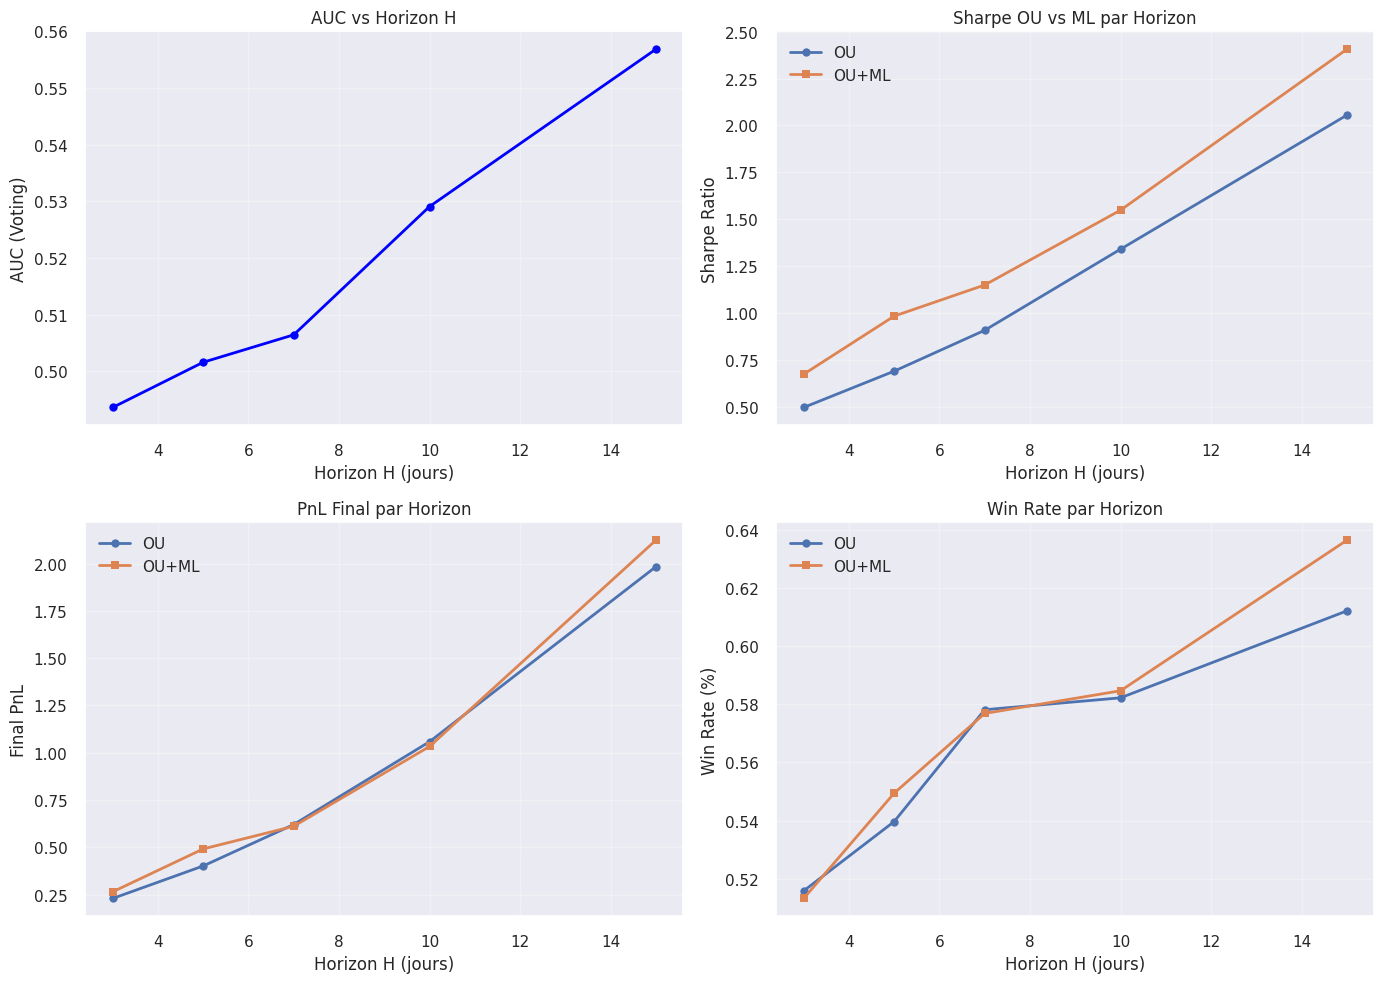


✅ Graphiques sauvegardés: gridsearch_H_analysis.png

🎯 HORIZON H OPTIMAL
H optimal (meilleur Sharpe ML): 15
  → Sharpe ML: 2.4066
  → PnL ML: 2.1233
  → AUC: 0.5568
  → Win-rate: 63.64%


In [ ]:
"""
Grid Search sur l'horizon H pour optimiser AUC et Sharpe
"""

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# 1. GRID SEARCH SUR H
# =========================================

h_values = [3, 5, 7, 10, 15]
results_h = []

for H in h_values:
    print(f"\n{'='*50}")
    print(f"Testing H = {H}")
    print(f"{'='*50}")

    # -------- Reconstruire datasets avec H différent --------
    datasets_h = []
    for A, B in pairs_for_ml:
        df_pair_h = build_dataset_for_pair(A, B, H=H)
        if len(df_pair_h) > 0:
            datasets_h.append(df_pair_h)

    if len(datasets_h) == 0:
        print(f"[WARN] Pas de données valides pour H={H}")
        continue

    df_ml_h = pd.concat(datasets_h, axis=0).sort_index()

    # -------- Split temporel --------
    X_h = df_ml_h.drop(columns=["y", "pair", "ou_pnl", "future_return"])
    y_h = df_ml_h["y"]

    split_h = int(0.7 * len(df_ml_h))
    X_train_h, X_test_h = X_h.iloc[:split_h], X_h.iloc[split_h:]
    y_train_h, y_test_h = y_h.iloc[:split_h], y_h.iloc[split_h:]
    df_train_h = df_ml_h.iloc[:split_h].copy()
    df_test_h = df_ml_h.iloc[split_h:].copy()

    print(f"Train: {len(X_train_h)} | Test: {len(X_test_h)}")
    print(f"Label distribution: {y_h.value_counts().to_dict()}")

    # -------- Construire les pipelines --------
    pipe_logit_h = Pipeline([
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(class_weight="balanced", max_iter=1000))
    ])

    pipe_rf_h = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(
            n_estimators=200,
            max_depth=6,
            min_samples_leaf=50,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ])

    # -------- Grid Search sur Logistic Regression --------
    tscv = TimeSeriesSplit(n_splits=5)

    param_grid_h = {
        "logit__C": [0.01, 0.1, 1, 10],
        "logit__penalty": ["l2"],
        "logit__solver": ["lbfgs"]
    }

    grid_logit_h = GridSearchCV(
        pipe_logit_h,
        param_grid_h,
        cv=tscv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=0
    )

    grid_logit_h.fit(X_train_h, y_train_h)
    best_logit_h = grid_logit_h.best_estimator_

    print(f"Best Logit params: {grid_logit_h.best_params_}")

    # -------- Fit Random Forest --------
    pipe_rf_h.fit(X_train_h, y_train_h)

    # -------- Créer Voting Classifier --------
    # ⚠️ IMPORTANT: utiliser best_logit_h, pas "..."
    voting_clf_h = VotingClassifier(
        estimators=[
            ("logit", best_logit_h),
            ("rf", pipe_rf_h)
        ],
        voting="soft"
    )

    voting_clf_h.fit(X_train_h, y_train_h)

    # -------- Évaluer les modèles --------
    y_prob_logit = best_logit_h.predict_proba(X_test_h)[:, 1]
    y_prob_rf = pipe_rf_h.predict_proba(X_test_h)[:, 1]
    y_prob_voting = voting_clf_h.predict_proba(X_test_h)[:, 1]

    auc_logit = roc_auc_score(y_test_h, y_prob_logit)
    auc_rf = roc_auc_score(y_test_h, y_prob_rf)
    auc_voting = roc_auc_score(y_test_h, y_prob_voting)

    # -------- Backtest avec ce H --------
    df_test_h["y_prob"] = y_prob_voting
    df_test_h["y_pred"] = voting_clf_h.predict(X_test_h)

    # Stratégies
    z_entry = 1.5
    prob_thresh = 0.5

    df_test_h["trade_ou"] = (df_test_h["zscore"].abs() > z_entry).astype(int)
    df_test_h["trade_ml"] = (
        (df_test_h["zscore"].abs() > z_entry) &
        (df_test_h["y_prob"] > prob_thresh)
    ).astype(int)

    df_test_h["pnl_ou"] = df_test_h["trade_ou"] * df_test_h["ou_pnl"]
    df_test_h["pnl_ml"] = df_test_h["trade_ml"] * df_test_h["ou_pnl"]

    # Risk-parity
    train_vol = df_train_h.groupby("pair")["ou_pnl"].std()
    weights = (1 / train_vol) / (1 / train_vol).sum()
    df_test_h["weight"] = df_test_h["pair"].map(weights)

    df_test_h["pnl_ou_port"] = df_test_h["pnl_ou"] * df_test_h["weight"]
    df_test_h["pnl_ml_port"] = df_test_h["pnl_ml"] * df_test_h["weight"]

    sharpe_ou = (df_test_h["pnl_ou_port"].mean() / df_test_h["pnl_ou_port"].std()) * np.sqrt(252)
    sharpe_ml = (df_test_h["pnl_ml_port"].mean() / df_test_h["pnl_ml_port"].std()) * np.sqrt(252)

    pnl_ou_final = df_test_h["pnl_ou_port"].sum()
    pnl_ml_final = df_test_h["pnl_ml_port"].sum()

    win_rate_ou = (df_test_h["pnl_ou"] > 0).sum() / max(df_test_h["trade_ou"].sum(), 1)
    win_rate_ml = (df_test_h["pnl_ml"] > 0).sum() / max(df_test_h["trade_ml"].sum(), 1)

    print(f"\n>>> AUC Logit: {auc_logit:.4f} | RF: {auc_rf:.4f} | Voting: {auc_voting:.4f}")
    print(f">>> Sharpe OU: {sharpe_ou:.4f} | Sharpe ML: {sharpe_ml:.4f}")
    print(f">>> PnL OU: {pnl_ou_final:.4f} | PnL ML: {pnl_ml_final:.4f}")
    print(f">>> Win-rate OU: {win_rate_ou:.2%} | ML: {win_rate_ml:.2%}")
    print(f">>> Nb trades OU: {df_test_h['trade_ou'].sum()} | ML: {df_test_h['trade_ml'].sum()}")

    # -------- Sauvegarder résultats --------
    results_h.append({
        "H": H,
        "n_samples": len(df_ml_h),
        "AUC_logit": auc_logit,
        "AUC_rf": auc_rf,
        "AUC_voting": auc_voting,
        "Sharpe_OU": sharpe_ou,
        "Sharpe_ML": sharpe_ml,
        "PnL_OU": pnl_ou_final,
        "PnL_ML": pnl_ml_final,
        "Win_rate_OU": win_rate_ou,
        "Win_rate_ML": win_rate_ml,
        "Trades_OU": df_test_h["trade_ou"].sum(),
        "Trades_ML": df_test_h["trade_ml"].sum()
    })

# =========================================
# 2. RÉSULTATS & VISUALISATION
# =========================================

results_h_df = pd.DataFrame(results_h)

print("\n" + "="*80)
print("RÉSUMÉ GRID SEARCH H")
print("="*80)
print(results_h_df.to_string())

# Sauvegarder
results_h_df.to_csv("gridsearch_H_results.csv", index=False)
print("\n✅ Résultats sauvegardés: gridsearch_H_results.csv")

# Visualiser
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AUC
axes[0, 0].plot(results_h_df["H"], results_h_df["AUC_voting"], marker="o", linewidth=2, color="blue")
axes[0, 0].set_xlabel("Horizon H (jours)")
axes[0, 0].set_ylabel("AUC (Voting)")
axes[0, 0].set_title("AUC vs Horizon H")
axes[0, 0].grid(True, alpha=0.3)

# Sharpe
axes[0, 1].plot(results_h_df["H"], results_h_df["Sharpe_OU"], marker="o", label="OU", linewidth=2)
axes[0, 1].plot(results_h_df["H"], results_h_df["Sharpe_ML"], marker="s", label="OU+ML", linewidth=2)
axes[0, 1].set_xlabel("Horizon H (jours)")
axes[0, 1].set_ylabel("Sharpe Ratio")
axes[0, 1].set_title("Sharpe OU vs ML par Horizon")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PnL
axes[1, 0].plot(results_h_df["H"], results_h_df["PnL_OU"], marker="o", label="OU", linewidth=2)
axes[1, 0].plot(results_h_df["H"], results_h_df["PnL_ML"], marker="s", label="OU+ML", linewidth=2)
axes[1, 0].set_xlabel("Horizon H (jours)")
axes[1, 0].set_ylabel("Final PnL")
axes[1, 0].set_title("PnL Final par Horizon")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Win-rate
axes[1, 1].plot(results_h_df["H"], results_h_df["Win_rate_OU"], marker="o", label="OU", linewidth=2)
axes[1, 1].plot(results_h_df["H"], results_h_df["Win_rate_ML"], marker="s", label="OU+ML", linewidth=2)
axes[1, 1].set_xlabel("Horizon H (jours)")
axes[1, 1].set_ylabel("Win Rate (%)")
axes[1, 1].set_title("Win Rate par Horizon")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("gridsearch_H_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✅ Graphiques sauvegardés: gridsearch_H_analysis.png")

# =========================================
# 3. RECOMMANDATION FINALE
# =========================================

best_h_idx = results_h_df["Sharpe_ML"].idxmax()
best_h = results_h_df.loc[best_h_idx]

print("\n" + "="*80)
print("🎯 HORIZON H OPTIMAL")
print("="*80)
print(f"H optimal (meilleur Sharpe ML): {int(best_h['H'])}")
print(f"  → Sharpe ML: {best_h['Sharpe_ML']:.4f}")
print(f"  → PnL ML: {best_h['PnL_ML']:.4f}")
print(f"  → AUC: {best_h['AUC_voting']:.4f}")
print(f"  → Win-rate: {best_h['Win_rate_ML']:.2%}")
print("="*80)